# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

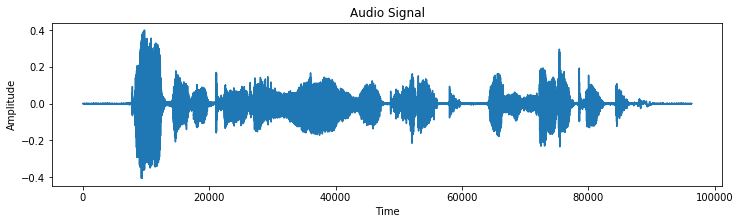

**Shape of Audio Signal** : (96359,)

**Transcript** : grandfather came down wearing a white shirt and his sunday coat

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

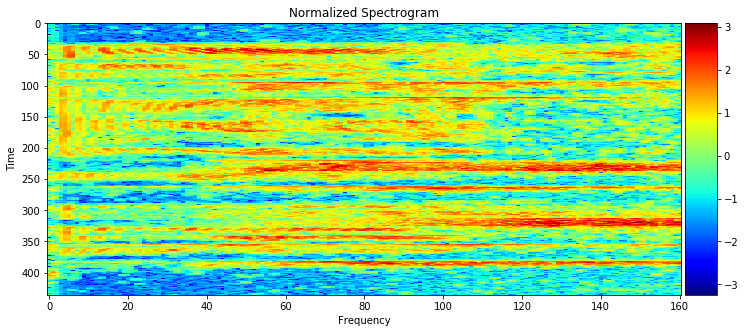

**Shape of Spectrogram** : (436, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

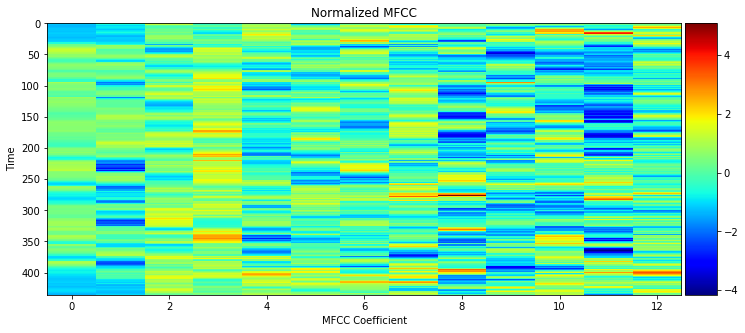

**Shape of MFCC** : (436, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [5]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [6]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [7]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 203s 2s/step - loss: 824.3044 - val_loss: 727.7349
Epoch 2/20
106/106 [==============================] - 207s 2s/step - loss: 751.8294 - val_loss: 726.8996
Epoch 3/20
106/106 [==============================] - 208s 2s/step - loss: 752.1915 - val_loss: 723.5729
Epoch 4/20
106/106 [==============================] - 209s 2s/step - loss: 750.7987 - val_loss: 721.8282
Epoch 5/20
106/106 [==============================] - 207s 2s/step - loss: 750.5600 - val_loss: 723.1020
Epoch 6/20
106/106 [==============================] - 204s 2s/step - loss: 751.7093 - val_loss: 729.4820
Epoch 7/20
106/106 [==============================] - 207s 2s/step - loss: 749.8391 - val_loss: 727.3840
Epoch 8/20
106/106 [==============================] - 206s 2s/step - loss: 751.2648 - val_loss: 721.4988
Epoch 9/20
106/106 [==============================] - 207s 2s/step - loss: 750.8432 - val_loss: 728.1796
Epoch 10/20
106/106 [==============================] - 

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [6]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [7]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 201s 2s/step - loss: 354.2709 - val_loss: 349.9166
Epoch 2/20
106/106 [==============================] - 206s 2s/step - loss: 228.4719 - val_loss: 213.6088
Epoch 3/20
106/106 [==============================] - 206s 2s/step - loss: 212.1724 - val_loss: 212.7862
Epoch 4/20
106/106 [==============================] - 206s 2s/step - loss: 186.1281 - val_loss: 220.5162
Epoch 5/20
106/106 [==============================] - 205s 2s/step - loss: 168.6109 - val_loss: 193.2156
Epoch 6/20
106/106 [==============================] - 205s 2s/step - loss: 160.3787 - val_loss: 169.9382
Epoch 7/20
106/106 [==============================] - 205s 2s/step - loss: 155.7887 - val_loss: 155.9972
Epoch 8/20
106/106 [==============================] - 205s 2s/step - loss: 152.0043 - val_loss: 152.7048
Epoch 9/20
106/106 [==============================] - 205s 2s/step - loss: 148.0692 - val_loss: 159.8179
Epoch 10/20
106/106 [==============================] - 

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [6]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         240600    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [7]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 110s 1s/step - loss: 228.2317 - val_loss: 236.7272
Epoch 2/20
106/106 [==============================] - 107s 1s/step - loss: 168.2328 - val_loss: 164.2041
Epoch 3/20
106/106 [==============================] - 106s 999ms/step - loss: 145.4187 - val_loss: 140.5073
Epoch 4/20
106/106 [==============================] - 105s 995ms/step - loss: 132.7645 - val_loss: 135.7540
Epoch 5/20
106/106 [==============================] - 106s 1s/step - loss: 123.4464 - val_loss: 132.2671
Epoch 6/20
106/106 [==============================] - 106s 1s/step - loss: 116.0905 - val_loss: 130.0852
Epoch 7/20
106/106 [==============================] - 105s 993ms/step - loss: 109.7901 - val_loss: 129.6480
Epoch 8/20
106/106 [==============================] - 105s 993ms/step - loss: 104.1409 - val_loss: 127.3742
Epoch 9/20
106/106 [==============================] - 105s 992ms/step - loss: 99.3126 - val_loss: 127.4201
Epoch 10/20
106/106 [====================

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [8]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         217200    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 200)         800       
_________________________________________________________________
rnn_2 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn_2 (BatchNormalization (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [9]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 371s 3s/step - loss: 281.9927 - val_loss: 235.5456
Epoch 2/20
106/106 [==============================] - 373s 4s/step - loss: 216.0766 - val_loss: 213.0397
Epoch 3/20
106/106 [==============================] - 374s 4s/step - loss: 182.2962 - val_loss: 167.3157
Epoch 4/20
106/106 [==============================] - 370s 3s/step - loss: 158.7011 - val_loss: 153.1465
Epoch 5/20
106/106 [==============================] - 374s 4s/step - loss: 147.1651 - val_loss: 147.2252
Epoch 6/20
106/106 [==============================] - 371s 3s/step - loss: 137.8029 - val_loss: 141.9943
Epoch 7/20
106/106 [==============================] - 370s 3s/step - loss: 135.6721 - val_loss: 140.9691
Epoch 8/20
106/106 [==============================] - 370s 3s/step - loss: 133.0639 - val_loss: 148.2723
Epoch 9/20
106/106 [==============================] - 374s 4s/step - loss: 132.5537 - val_loss: 146.4680
Epoch 10/20
106/106 [==============================] - 

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [10]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [ ]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 349s 3s/step - loss: 310.2101 - val_loss: 226.1554
Epoch 2/20
106/106 [==============================] - 348s 3s/step - loss: 231.1664 - val_loss: 213.1995
Epoch 3/20
106/106 [==============================] - 350s 3s/step - loss: 221.3576 - val_loss: 208.5177
Epoch 4/20
106/106 [==============================] - 347s 3s/step - loss: 216.3543 - val_loss: 199.0996
Epoch 5/20
106/106 [==============================] - 347s 3s/step - loss: 204.0386 - val_loss: 188.6229
Epoch 6/20
106/106 [==============================] - 352s 3s/step - loss: 187.6809 - val_loss: 179.8511
Epoch 7/20
106/106 [==============================] - 347s 3s/step - loss: 176.0637 - val_loss: 166.2105
Epoch 8/20
106/106 [==============================] - 350s 3s/step - loss: 166.1257 - val_loss: 161.6092
Epoch 9/20
106/106 [==============================] - 352s 3s/step - loss: 157.3939 - val_loss: 154.3768
Epoch 10/20
106/106 [==============================] - 

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [ ]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

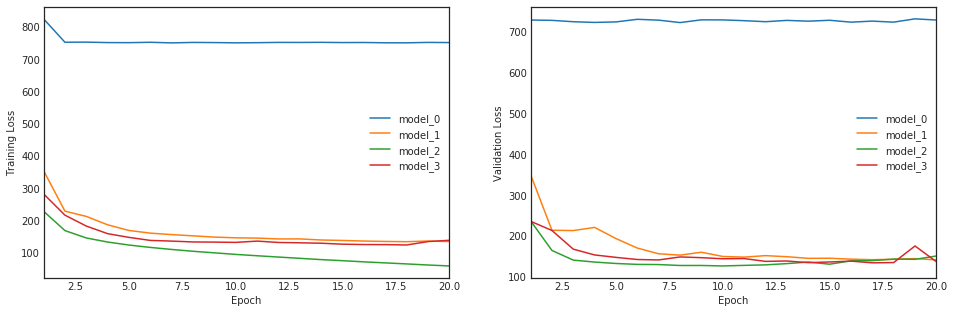

In [6]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__

* model_0 is a very basic model and it really underfits the data. As the model is really simple, it fails to capture the underlying complexity of the data.

* model_1 is a significant improvement over model_0. It incorporates GRUs with Batchnormalization and Time Distributed Dense layers. Batch Normalization is necessary to correctly capture the variance of the data, and the TimeDistributed layer also allows the model to convey the transitions between the temporal slices. With these new layers, both the training and validation loss decrease significantly.

* model_2 improves the performance over model_1 by adding a 1D convolutional layer, which allows for a faster convergence to lower validation loss values. This can be explained because the convolutional architecture captures relationships that account for the context.

* model_3 has the addition of more RNN layers, which increases complexity and thus performs clearly better than model_1

* model_4 features the bidirectional RNN, which surprisingly does not perform as well as the other architectures.

The best performing model is model_2: it has the lowest validation error after fewer epochs than the rest. This is probably because it features a CNN component which has been shown to capture complex relationships in the input data. It is also clear that Batch Normalization is a must-have for any model working with Speech Recognition, as is the TimeDistributedDense layer.

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [16]:
# specify the model
model_end = final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        dropout= 0.2,
                        units=200)

/opt/conda/lib/python3.6/site-packages/keras/layers/recurrent.py:1004: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 400)         721200    
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [18]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=False) # change to Fal-se if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 410s 4s/step - loss: 223.3991 - val_loss: 224.3313
Epoch 2/20
106/106 [==============================] - 401s 4s/step - loss: 171.8520 - val_loss: 152.4281
Epoch 3/20
106/106 [==============================] - 405s 4s/step - loss: 143.6603 - val_loss: 132.3019
Epoch 4/20
106/106 [==============================] - 408s 4s/step - loss: 128.6684 - val_loss: 124.9801
Epoch 5/20
106/106 [==============================] - 409s 4s/step - loss: 118.3174 - val_loss: 116.8875
Epoch 6/20
106/106 [==============================] - 412s 4s/step - loss: 110.2653 - val_loss: 112.6052
Epoch 7/20
106/106 [==============================] - 409s 4s/step - loss: 103.4165 - val_loss: 109.0254
Epoch 8/20
106/106 [==============================] - 410s 4s/step - loss: 97.4939 - val_loss: 108.0666
Epoch 9/20
106/106 [==============================] - 414s 4s/step - loss: 92.1291 - val_loss: 105.4968
Epoch 10/20
106/106 [==============================] - 41

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__

My final model consists of 1 CNN, 1 RNN layer as I saw their effectiveness in model_2. I decided to add 20% Dropout rate in the RNN layer to help prevent overfitting, as we are working with a more complex model here which also includes 2 Bidirectional layers along with time distributed dense layers and batch normalizations. I decided to try the Bidirectional ones as an experiment, that is: to combine CNN+RNN+2BD. I also decided to use MFCC features this time for experimentation reasons.

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [25]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator(spectrogram=False)
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [26]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=model_end, 
                model_path='results/model_end.h5')

--------------------------------------------------------------------------------
True transcription:

grandfather came down wearing a white shirt and his sunday coat
--------------------------------------------------------------------------------
Predicted transcription:

gran father came down wearing a lite sirt and whoi sunda cot
--------------------------------------------------------------------------------


Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [29]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=model_end, 
                model_path='results/model_end.h5')

--------------------------------------------------------------------------------
True transcription:

in short he becomes a prominent figure in london society and if he is not careful somebody will say so
--------------------------------------------------------------------------------
Predicted transcription:

i srt he be comes eprommen tigur im onof the siny and be fhiise not carfl subyail sasov
--------------------------------------------------------------------------------


One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!

In [30]:
!tar cvfz notebook.tar.gz *

CODEOWNERS
LICENSE.txt
LibriSpeech/
LibriSpeech/BOOKS.TXT
LibriSpeech/LICENSE.TXT
LibriSpeech/CHAPTERS.TXT
LibriSpeech/flac_to_wav.sh
LibriSpeech/test-clean/
LibriSpeech/test-clean/7176/
LibriSpeech/test-clean/7176/92135/
LibriSpeech/test-clean/7176/92135/7176-92135-0025.wav
LibriSpeech/test-clean/7176/92135/7176-92135-0009.wav
LibriSpeech/test-clean/7176/92135/7176-92135-0021.wav
LibriSpeech/test-clean/7176/92135/7176-92135-0021.flac
LibriSpeech/test-clean/7176/92135/7176-92135-0029.wav
LibriSpeech/test-clean/7176/92135/7176-92135-0026.wav
LibriSpeech/test-clean/7176/92135/7176-92135-0005.flac
LibriSpeech/test-clean/7176/92135/7176-92135-0027.wav
LibriSpeech/test-clean/7176/92135/7176-92135-0007.wav
LibriSpeech/test-clean/7176/92135/7176-92135-0000.flac
LibriSpeech/test-clean/7176/92135/7176-92135-0023.flac
LibriSpeech/test-clean/7176/92135/7176-92135-0043.flac
LibriSpeech/test-clean/7176/92135/7176-92135-0034.flac
LibriSpeech/test-clean/7176/92135/7176-92135-0010.wav
LibriSpeech/test

LibriSpeech/test-clean/7176/88083/7176-88083-0026.wav
LibriSpeech/test-clean/7176/88083/7176-88083-0014.flac
LibriSpeech/test-clean/7176/88083/7176-88083-0025.flac
LibriSpeech/test-clean/121/
LibriSpeech/test-clean/121/123852/
LibriSpeech/test-clean/121/123852/121-123852-0000.flac
LibriSpeech/test-clean/121/123852/121-123852-0004.flac
LibriSpeech/test-clean/121/123852/121-123852-0004.wav
LibriSpeech/test-clean/121/123852/121-123852-0000.wav
LibriSpeech/test-clean/121/123852/121-123852-0002.wav
LibriSpeech/test-clean/121/123852/121-123852-0001.wav
LibriSpeech/test-clean/121/123852/121-123852-0001.flac
LibriSpeech/test-clean/121/123852/121-123852-0003.wav
LibriSpeech/test-clean/121/123852/121-123852-0002.flac
LibriSpeech/test-clean/121/123852/121-123852.trans.txt
LibriSpeech/test-clean/121/123852/121-123852-0003.flac
LibriSpeech/test-clean/121/121726/
LibriSpeech/test-clean/121/121726/121-121726-0010.flac
LibriSpeech/test-clean/121/121726/121-121726-0013.wav
LibriSpeech/test-clean/121/12

LibriSpeech/test-clean/5639/40744/5639-40744-0026.wav
LibriSpeech/test-clean/5639/40744/5639-40744-0004.flac
LibriSpeech/test-clean/5639/40744/5639-40744-0010.wav
LibriSpeech/test-clean/5639/40744/5639-40744-0036.wav
LibriSpeech/test-clean/5639/40744/5639-40744-0000.wav
LibriSpeech/test-clean/5639/40744/5639-40744-0016.wav
LibriSpeech/test-clean/5639/40744/5639-40744-0030.wav
LibriSpeech/test-clean/5639/40744/5639-40744-0012.flac
LibriSpeech/test-clean/5639/40744/5639-40744-0032.wav
LibriSpeech/test-clean/5639/40744/5639-40744-0019.flac
LibriSpeech/test-clean/5639/40744/5639-40744-0034.wav
LibriSpeech/test-clean/5639/40744/5639-40744-0021.wav
LibriSpeech/test-clean/5639/40744/5639-40744-0002.wav
LibriSpeech/test-clean/5639/40744/5639-40744-0035.flac
LibriSpeech/test-clean/5639/40744/5639-40744-0007.wav
LibriSpeech/test-clean/5639/40744/5639-40744-0038.flac
LibriSpeech/test-clean/5639/40744/5639-40744-0025.wav
LibriSpeech/test-clean/5639/40744/5639-40744-0016.flac
LibriSpeech/test-clean

LibriSpeech/test-clean/6829/68769/6829-68769-0025.flac
LibriSpeech/test-clean/6829/68769/6829-68769-0005.wav
LibriSpeech/test-clean/6829/68769/6829-68769-0006.flac
LibriSpeech/test-clean/6829/68769/6829-68769-0003.flac
LibriSpeech/test-clean/6829/68769/6829-68769-0043.flac
LibriSpeech/test-clean/6829/68769/6829-68769-0041.wav
LibriSpeech/test-clean/6829/68769/6829-68769-0018.flac
LibriSpeech/test-clean/6829/68769/6829-68769-0007.wav
LibriSpeech/test-clean/6829/68769/6829-68769-0030.flac
LibriSpeech/test-clean/6829/68769/6829-68769-0029.wav
LibriSpeech/test-clean/6829/68769/6829-68769-0021.flac
LibriSpeech/test-clean/6829/68769/6829-68769-0035.flac
LibriSpeech/test-clean/6829/68769/6829-68769-0008.wav
LibriSpeech/test-clean/6829/68769/6829-68769-0015.flac
LibriSpeech/test-clean/6829/68769/6829-68769-0014.wav
LibriSpeech/test-clean/6829/68769/6829-68769-0048.flac
LibriSpeech/test-clean/6829/68769/6829-68769-0043.wav
LibriSpeech/test-clean/6829/68769/6829-68769-0021.wav
LibriSpeech/test-c

LibriSpeech/test-clean/6829/68771/6829-68771-0031.flac
LibriSpeech/test-clean/6829/68771/6829-68771-0007.flac
LibriSpeech/test-clean/6829/68771/6829-68771-0011.flac
LibriSpeech/test-clean/6829/68771/6829-68771-0021.flac
LibriSpeech/test-clean/6829/68771/6829-68771-0036.flac
LibriSpeech/test-clean/6829/68771/6829-68771-0000.wav
LibriSpeech/test-clean/6829/68771/6829-68771-0033.wav
LibriSpeech/test-clean/6829/68771/6829-68771-0036.wav
LibriSpeech/test-clean/6829/68771/6829-68771-0018.flac
LibriSpeech/test-clean/6829/68771/6829-68771-0030.wav
LibriSpeech/test-clean/6829/68771/6829-68771-0029.flac
LibriSpeech/test-clean/6829/68771/6829-68771-0026.wav
LibriSpeech/test-clean/6829/68771/6829-68771-0020.wav
LibriSpeech/test-clean/6829/68771/6829-68771-0032.wav
LibriSpeech/test-clean/6829/68771/6829-68771-0006.flac
LibriSpeech/test-clean/6829/68771/6829-68771-0015.wav
LibriSpeech/test-clean/6829/68771/6829-68771.trans.txt
LibriSpeech/test-clean/6829/68771/6829-68771-0034.flac
LibriSpeech/test-c

LibriSpeech/test-clean/8555/292519/8555-292519-0006.wav
LibriSpeech/test-clean/8555/292519/8555-292519-0007.flac
LibriSpeech/test-clean/8555/292519/8555-292519-0003.wav
LibriSpeech/test-clean/8555/292519/8555-292519-0010.flac
LibriSpeech/test-clean/8555/292519/8555-292519-0002.flac
LibriSpeech/test-clean/8555/292519/8555-292519-0000.wav
LibriSpeech/test-clean/8555/292519/8555-292519-0013.flac
LibriSpeech/test-clean/8555/292519/8555-292519-0006.flac
LibriSpeech/test-clean/8555/292519/8555-292519-0011.flac
LibriSpeech/test-clean/2961/
LibriSpeech/test-clean/2961/960/
LibriSpeech/test-clean/2961/960/2961-960-0016.flac
LibriSpeech/test-clean/2961/960/2961-960-0007.flac
LibriSpeech/test-clean/2961/960/2961-960-0003.wav
LibriSpeech/test-clean/2961/960/2961-960-0009.flac
LibriSpeech/test-clean/2961/960/2961-960-0015.wav
LibriSpeech/test-clean/2961/960/2961-960-0000.wav
LibriSpeech/test-clean/2961/960/2961-960-0001.wav
LibriSpeech/test-clean/2961/960/2961-960-0012.wav
LibriSpeech/test-clean/29

LibriSpeech/test-clean/1284/1180/1284-1180-0020.flac
LibriSpeech/test-clean/1284/1180/1284-1180-0023.flac
LibriSpeech/test-clean/1284/1180/1284-1180-0009.flac
LibriSpeech/test-clean/1284/1180/1284-1180-0015.flac
LibriSpeech/test-clean/1284/1180/1284-1180-0008.flac
LibriSpeech/test-clean/1284/1180/1284-1180-0018.flac
LibriSpeech/test-clean/1284/1180/1284-1180-0004.flac
LibriSpeech/test-clean/1284/1180/1284-1180-0022.wav
LibriSpeech/test-clean/1284/1180/1284-1180-0030.wav
LibriSpeech/test-clean/1284/1180/1284-1180-0023.wav
LibriSpeech/test-clean/1284/1180/1284-1180-0010.wav
LibriSpeech/test-clean/1284/1180/1284-1180-0029.wav
LibriSpeech/test-clean/1284/1180/1284-1180-0032.flac
LibriSpeech/test-clean/1284/1181/
LibriSpeech/test-clean/1284/1181/1284-1181-0008.flac
LibriSpeech/test-clean/1284/1181/1284-1181-0015.flac
LibriSpeech/test-clean/1284/1181/1284-1181-0013.wav
LibriSpeech/test-clean/1284/1181/1284-1181-0002.wav
LibriSpeech/test-clean/1284/1181/1284-1181-0001.flac
LibriSpeech/test-cl

LibriSpeech/test-clean/61/70968/61-70968-0008.flac
LibriSpeech/test-clean/61/70968/61-70968-0032.wav
LibriSpeech/test-clean/61/70968/61-70968-0019.flac
LibriSpeech/test-clean/61/70968/61-70968-0055.wav
LibriSpeech/test-clean/61/70968/61-70968-0040.flac
LibriSpeech/test-clean/61/70968/61-70968-0010.flac
LibriSpeech/test-clean/61/70968/61-70968-0061.flac
LibriSpeech/test-clean/61/70968/61-70968-0045.flac
LibriSpeech/test-clean/61/70968/61-70968-0044.flac
LibriSpeech/test-clean/61/70968/61-70968-0042.flac
LibriSpeech/test-clean/61/70968/61-70968-0060.wav
LibriSpeech/test-clean/61/70968/61-70968-0028.flac
LibriSpeech/test-clean/61/70968/61-70968-0062.flac
LibriSpeech/test-clean/61/70968/61-70968-0002.flac
LibriSpeech/test-clean/61/70968/61-70968-0044.wav
LibriSpeech/test-clean/61/70968/61-70968-0037.wav
LibriSpeech/test-clean/61/70968/61-70968-0037.flac
LibriSpeech/test-clean/61/70968/61-70968-0034.flac
LibriSpeech/test-clean/61/70968/61-70968-0033.flac
LibriSpeech/test-clean/61/70968/61-7

LibriSpeech/test-clean/4970/29095/4970-29095-0021.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0030.flac
LibriSpeech/test-clean/4970/29095/4970-29095-0008.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0014.flac
LibriSpeech/test-clean/4970/29095/4970-29095-0029.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0035.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0026.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0027.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0002.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0030.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0031.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0001.flac
LibriSpeech/test-clean/4970/29095/4970-29095-0038.flac
LibriSpeech/test-clean/4970/29095/4970-29095-0036.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0034.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0023.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0011.wav
LibriSpeech/test-clean/4970/29095/4970-29095-0025.flac
LibriSpeech/test-clean/

LibriSpeech/test-clean/8455/210777/8455-210777-0021.flac
LibriSpeech/test-clean/8455/210777/8455-210777-0028.wav
LibriSpeech/test-clean/8455/210777/8455-210777-0027.flac
LibriSpeech/test-clean/8455/210777/8455-210777-0045.flac
LibriSpeech/test-clean/8455/210777/8455-210777-0030.flac
LibriSpeech/test-clean/8455/210777/8455-210777-0070.wav
LibriSpeech/test-clean/8455/210777/8455-210777-0052.flac
LibriSpeech/test-clean/8455/210777/8455-210777-0057.wav
LibriSpeech/test-clean/8455/210777/8455-210777-0041.wav
LibriSpeech/test-clean/8455/210777/8455-210777-0053.flac
LibriSpeech/test-clean/8455/210777/8455-210777-0063.wav
LibriSpeech/test-clean/8455/210777/8455-210777-0048.flac
LibriSpeech/test-clean/8455/210777/8455-210777-0059.wav
LibriSpeech/test-clean/8455/210777/8455-210777-0058.flac
LibriSpeech/test-clean/8455/210777/8455-210777-0058.wav
LibriSpeech/test-clean/8455/210777/8455-210777-0051.wav
LibriSpeech/test-clean/8455/210777/8455-210777-0068.flac
LibriSpeech/test-clean/8455/210777/8455

LibriSpeech/test-clean/6930/81414/6930-81414-0023.wav
LibriSpeech/test-clean/6930/81414/6930-81414-0012.flac
LibriSpeech/test-clean/6930/81414/6930-81414-0019.flac
LibriSpeech/test-clean/6930/81414/6930-81414-0008.flac
LibriSpeech/test-clean/6930/81414/6930-81414-0013.flac
LibriSpeech/test-clean/6930/81414/6930-81414.trans.txt
LibriSpeech/test-clean/6930/81414/6930-81414-0010.wav
LibriSpeech/test-clean/6930/81414/6930-81414-0010.flac
LibriSpeech/test-clean/6930/81414/6930-81414-0005.flac
LibriSpeech/test-clean/6930/81414/6930-81414-0017.flac
LibriSpeech/test-clean/6930/81414/6930-81414-0005.wav
LibriSpeech/test-clean/6930/81414/6930-81414-0016.wav
LibriSpeech/test-clean/6930/81414/6930-81414-0004.flac
LibriSpeech/test-clean/6930/81414/6930-81414-0026.wav
LibriSpeech/test-clean/6930/81414/6930-81414-0020.wav
LibriSpeech/test-clean/6930/81414/6930-81414-0017.wav
LibriSpeech/test-clean/6930/81414/6930-81414-0016.flac
LibriSpeech/test-clean/6930/81414/6930-81414-0023.flac
LibriSpeech/test-

LibriSpeech/test-clean/4077/13754/4077-13754-0011.wav
LibriSpeech/test-clean/4077/13754/4077-13754-0006.wav
LibriSpeech/test-clean/4077/13754/4077-13754-0010.wav
LibriSpeech/test-clean/4077/13754/4077-13754-0003.wav
LibriSpeech/test-clean/4077/13754/4077-13754-0016.wav
LibriSpeech/test-clean/4077/13754/4077-13754-0001.wav
LibriSpeech/test-clean/4077/13754/4077-13754-0010.flac
LibriSpeech/test-clean/4077/13754/4077-13754-0008.flac
LibriSpeech/test-clean/4077/13754/4077-13754-0012.wav
LibriSpeech/test-clean/4077/13754/4077-13754-0000.flac
LibriSpeech/test-clean/4077/13754/4077-13754-0008.wav
LibriSpeech/test-clean/4077/13754/4077-13754-0006.flac
LibriSpeech/test-clean/4077/13754/4077-13754-0009.flac
LibriSpeech/test-clean/4077/13754/4077-13754-0007.flac
LibriSpeech/test-clean/4077/13754/4077-13754-0009.wav
LibriSpeech/test-clean/4077/13754/4077-13754-0013.wav
LibriSpeech/test-clean/4077/13754/4077-13754-0014.wav
LibriSpeech/test-clean/4077/13754/4077-13754-0007.wav
LibriSpeech/test-clean

LibriSpeech/test-clean/3729/6852/3729-6852-0017.flac
LibriSpeech/test-clean/3729/6852/3729-6852-0041.wav
LibriSpeech/test-clean/3729/6852/3729-6852-0037.wav
LibriSpeech/test-clean/3729/6852/3729-6852-0015.flac
LibriSpeech/test-clean/3729/6852/3729-6852-0010.flac
LibriSpeech/test-clean/3729/6852/3729-6852-0014.wav
LibriSpeech/test-clean/3729/6852/3729-6852-0039.wav
LibriSpeech/test-clean/3729/6852/3729-6852-0038.wav
LibriSpeech/test-clean/3729/6852/3729-6852-0008.flac
LibriSpeech/test-clean/3729/6852/3729-6852-0027.flac
LibriSpeech/test-clean/3729/6852/3729-6852-0006.flac
LibriSpeech/test-clean/3729/6852/3729-6852-0044.wav
LibriSpeech/test-clean/3729/6852/3729-6852-0042.flac
LibriSpeech/test-clean/3729/6852/3729-6852-0001.wav
LibriSpeech/test-clean/3729/6852/3729-6852-0040.flac
LibriSpeech/test-clean/3729/6852/3729-6852-0025.flac
LibriSpeech/test-clean/3729/6852/3729-6852-0013.flac
LibriSpeech/test-clean/3729/6852/3729-6852-0005.wav
LibriSpeech/test-clean/3729/6852/3729-6852-0031.flac
L

LibriSpeech/test-clean/7127/75947/7127-75947-0000.flac
LibriSpeech/test-clean/7127/75947/7127-75947-0012.flac
LibriSpeech/test-clean/7127/75947/7127-75947-0015.flac
LibriSpeech/test-clean/7127/75947/7127-75947-0037.wav
LibriSpeech/test-clean/7127/75947/7127-75947-0003.flac
LibriSpeech/test-clean/7127/75947/7127-75947-0014.wav
LibriSpeech/test-clean/7127/75947/7127-75947-0001.wav
LibriSpeech/test-clean/7127/75947/7127-75947-0037.flac
LibriSpeech/test-clean/7127/75947/7127-75947-0018.flac
LibriSpeech/test-clean/7127/75947/7127-75947-0030.flac
LibriSpeech/test-clean/7127/75947/7127-75947-0009.flac
LibriSpeech/test-clean/7127/75947/7127-75947-0013.wav
LibriSpeech/test-clean/7127/75947/7127-75947-0016.wav
LibriSpeech/test-clean/7127/75947/7127-75947-0004.flac
LibriSpeech/test-clean/7127/75947/7127-75947-0021.wav
LibriSpeech/test-clean/7127/75947/7127-75947-0005.flac
LibriSpeech/test-clean/7127/75947/7127-75947-0008.wav
LibriSpeech/test-clean/7127/75947/7127-75947-0006.wav
LibriSpeech/test-c

LibriSpeech/test-clean/4446/2275/4446-2275-0011.flac
LibriSpeech/test-clean/4446/2275/4446-2275-0009.flac
LibriSpeech/test-clean/4446/2275/4446-2275-0019.flac
LibriSpeech/test-clean/4446/2275/4446-2275-0006.flac
LibriSpeech/test-clean/4446/2275/4446-2275-0024.wav
LibriSpeech/test-clean/4446/2275/4446-2275-0016.flac
LibriSpeech/test-clean/4446/2275/4446-2275-0043.wav
LibriSpeech/test-clean/4446/2275/4446-2275-0034.wav
LibriSpeech/test-clean/4446/2275/4446-2275-0033.flac
LibriSpeech/test-clean/4446/2275/4446-2275-0014.flac
LibriSpeech/test-clean/4446/2275/4446-2275-0008.flac
LibriSpeech/test-clean/4446/2275/4446-2275-0025.wav
LibriSpeech/test-clean/4446/2275/4446-2275-0005.flac
LibriSpeech/test-clean/4446/2275/4446-2275-0026.flac
LibriSpeech/test-clean/4446/2275/4446-2275-0007.flac
LibriSpeech/test-clean/4446/2275/4446-2275-0035.wav
LibriSpeech/test-clean/4446/2275/4446-2275-0001.flac
LibriSpeech/test-clean/4446/2275/4446-2275-0014.wav
LibriSpeech/test-clean/4446/2275/4446-2275-0019.wav


LibriSpeech/test-clean/8463/294828/8463-294828-0021.flac
LibriSpeech/test-clean/8463/294828/8463-294828-0006.flac
LibriSpeech/test-clean/8463/294828/8463-294828.trans.txt
LibriSpeech/test-clean/8463/294828/8463-294828-0021.wav
LibriSpeech/test-clean/8463/294828/8463-294828-0027.wav
LibriSpeech/test-clean/8463/294828/8463-294828-0038.flac
LibriSpeech/test-clean/8463/294828/8463-294828-0025.flac
LibriSpeech/test-clean/8463/294828/8463-294828-0018.wav
LibriSpeech/test-clean/8463/294828/8463-294828-0034.flac
LibriSpeech/test-clean/8463/294828/8463-294828-0018.flac
LibriSpeech/test-clean/8463/294828/8463-294828-0019.flac
LibriSpeech/test-clean/8463/294828/8463-294828-0033.wav
LibriSpeech/test-clean/8463/294828/8463-294828-0023.flac
LibriSpeech/test-clean/8463/294828/8463-294828-0009.flac
LibriSpeech/test-clean/8463/294828/8463-294828-0014.flac
LibriSpeech/test-clean/8463/294828/8463-294828-0033.flac
LibriSpeech/test-clean/8463/294828/8463-294828-0013.flac
LibriSpeech/test-clean/8463/294828/

LibriSpeech/test-clean/5142/33396/5142-33396-0034.flac
LibriSpeech/test-clean/5142/33396/5142-33396-0030.flac
LibriSpeech/test-clean/5142/33396/5142-33396-0006.flac
LibriSpeech/test-clean/5142/33396/5142-33396-0010.flac
LibriSpeech/test-clean/5142/33396/5142-33396-0060.flac
LibriSpeech/test-clean/5142/33396/5142-33396-0037.wav
LibriSpeech/test-clean/5142/33396/5142-33396-0027.wav
LibriSpeech/test-clean/5142/33396/5142-33396-0044.flac
LibriSpeech/test-clean/5142/33396/5142-33396-0057.flac
LibriSpeech/test-clean/5142/33396/5142-33396-0060.wav
LibriSpeech/test-clean/5142/33396/5142-33396-0013.flac
LibriSpeech/test-clean/5142/33396/5142-33396-0045.flac
LibriSpeech/test-clean/5142/33396/5142-33396-0048.wav
LibriSpeech/test-clean/5142/33396/5142-33396-0064.flac
LibriSpeech/test-clean/5142/33396/5142-33396-0054.flac
LibriSpeech/test-clean/5142/33396/5142-33396-0020.wav
LibriSpeech/test-clean/5142/33396/5142-33396-0053.flac
LibriSpeech/test-clean/5142/33396/5142-33396-0062.wav
LibriSpeech/test

LibriSpeech/test-clean/5142/36377/5142-36377-0021.flac
LibriSpeech/test-clean/5142/36377/5142-36377-0004.flac
LibriSpeech/test-clean/5142/36377/5142-36377-0018.flac
LibriSpeech/test-clean/5142/36377/5142-36377-0007.wav
LibriSpeech/test-clean/5142/36377/5142-36377-0017.wav
LibriSpeech/test-clean/5142/36377/5142-36377-0002.flac
LibriSpeech/test-clean/5142/36377/5142-36377-0005.flac
LibriSpeech/test-clean/5142/36377/5142-36377-0019.flac
LibriSpeech/test-clean/5142/36377/5142-36377-0006.wav
LibriSpeech/test-clean/5142/36377/5142-36377-0015.flac
LibriSpeech/test-clean/5142/36377/5142-36377-0020.wav
LibriSpeech/test-clean/5142/36377/5142-36377-0013.flac
LibriSpeech/test-clean/5142/36377/5142-36377-0008.wav
LibriSpeech/test-clean/5142/36377/5142-36377-0009.flac
LibriSpeech/test-clean/5142/36377/5142-36377-0018.wav
LibriSpeech/test-clean/5142/36377/5142-36377-0023.wav
LibriSpeech/test-clean/5142/36377/5142-36377-0009.wav
LibriSpeech/test-clean/5142/36377/5142-36377-0003.flac
LibriSpeech/test-c

LibriSpeech/test-clean/3575/170457/3575-170457-0036.flac
LibriSpeech/test-clean/3575/170457/3575-170457-0006.wav
LibriSpeech/test-clean/672/
LibriSpeech/test-clean/672/122797/
LibriSpeech/test-clean/672/122797/672-122797-0019.flac
LibriSpeech/test-clean/672/122797/672-122797-0049.flac
LibriSpeech/test-clean/672/122797/672-122797-0002.wav
LibriSpeech/test-clean/672/122797/672-122797-0021.flac
LibriSpeech/test-clean/672/122797/672-122797-0025.wav
LibriSpeech/test-clean/672/122797/672-122797-0034.flac
LibriSpeech/test-clean/672/122797/672-122797-0051.flac
LibriSpeech/test-clean/672/122797/672-122797-0027.wav
LibriSpeech/test-clean/672/122797/672-122797-0042.flac
LibriSpeech/test-clean/672/122797/672-122797-0065.flac
LibriSpeech/test-clean/672/122797/672-122797-0074.flac
LibriSpeech/test-clean/672/122797/672-122797-0012.wav
LibriSpeech/test-clean/672/122797/672-122797-0024.wav
LibriSpeech/test-clean/672/122797/672-122797-0060.flac
LibriSpeech/test-clean/672/122797/672-122797-0062.wav
Libri

LibriSpeech/test-clean/672/122797/672-122797-0072.flac
LibriSpeech/test-clean/4992/
LibriSpeech/test-clean/4992/41797/
LibriSpeech/test-clean/4992/41797/4992-41797-0019.flac
LibriSpeech/test-clean/4992/41797/4992-41797-0008.wav
LibriSpeech/test-clean/4992/41797/4992-41797-0017.flac
LibriSpeech/test-clean/4992/41797/4992-41797-0007.wav
LibriSpeech/test-clean/4992/41797/4992-41797-0012.wav
LibriSpeech/test-clean/4992/41797/4992-41797-0010.wav
LibriSpeech/test-clean/4992/41797/4992-41797-0000.wav
LibriSpeech/test-clean/4992/41797/4992-41797-0008.flac
LibriSpeech/test-clean/4992/41797/4992-41797-0020.wav
LibriSpeech/test-clean/4992/41797/4992-41797-0013.wav
LibriSpeech/test-clean/4992/41797/4992-41797-0015.flac
LibriSpeech/test-clean/4992/41797/4992-41797-0000.flac
LibriSpeech/test-clean/4992/41797/4992-41797-0009.flac
LibriSpeech/test-clean/4992/41797/4992-41797-0015.wav
LibriSpeech/test-clean/4992/41797/4992-41797-0013.flac
LibriSpeech/test-clean/4992/41797/4992-41797-0021.wav
LibriSpeec

LibriSpeech/test-clean/908/31957/908-31957-0004.wav
LibriSpeech/test-clean/908/31957/908-31957-0015.flac
LibriSpeech/test-clean/908/31957/908-31957-0024.flac
LibriSpeech/test-clean/908/31957/908-31957-0008.wav
LibriSpeech/test-clean/908/31957/908-31957-0011.wav
LibriSpeech/test-clean/908/31957/908-31957-0023.flac
LibriSpeech/test-clean/908/31957/908-31957-0005.wav
LibriSpeech/test-clean/908/31957/908-31957-0009.wav
LibriSpeech/test-clean/908/31957/908-31957-0005.flac
LibriSpeech/test-clean/908/31957/908-31957-0025.flac
LibriSpeech/test-clean/908/31957/908-31957-0007.wav
LibriSpeech/test-clean/908/31957/908-31957.trans.txt
LibriSpeech/test-clean/908/31957/908-31957-0007.flac
LibriSpeech/test-clean/908/31957/908-31957-0014.flac
LibriSpeech/test-clean/908/31957/908-31957-0017.wav
LibriSpeech/test-clean/908/31957/908-31957-0001.wav
LibriSpeech/test-clean/908/31957/908-31957-0004.flac
LibriSpeech/test-clean/908/31957/908-31957-0000.wav
LibriSpeech/test-clean/908/31957/908-31957-0018.wav
Lib

LibriSpeech/test-clean/2300/131720/2300-131720-0029.wav
LibriSpeech/test-clean/2300/131720/2300-131720-0009.wav
LibriSpeech/test-clean/2300/131720/2300-131720-0017.wav
LibriSpeech/test-clean/2300/131720/2300-131720-0035.flac
LibriSpeech/test-clean/2300/131720/2300-131720-0018.wav
LibriSpeech/test-clean/2300/131720/2300-131720-0004.wav
LibriSpeech/test-clean/2300/131720/2300-131720-0029.flac
LibriSpeech/test-clean/2300/131720/2300-131720-0011.wav
LibriSpeech/test-clean/2300/131720/2300-131720-0038.wav
LibriSpeech/test-clean/2300/131720/2300-131720-0008.flac
LibriSpeech/test-clean/2300/131720/2300-131720-0002.flac
LibriSpeech/test-clean/2300/131720/2300-131720-0011.flac
LibriSpeech/test-clean/2300/131720/2300-131720-0027.wav
LibriSpeech/test-clean/2300/131720/2300-131720-0022.wav
LibriSpeech/test-clean/2300/131720/2300-131720-0003.wav
LibriSpeech/test-clean/2300/131720/2300-131720-0015.wav
LibriSpeech/test-clean/2300/131720/2300-131720-0017.flac
LibriSpeech/test-clean/2300/131720/2300-13

LibriSpeech/test-clean/260/123440/260-123440-0017.wav
LibriSpeech/test-clean/260/123440/260-123440-0014.flac
LibriSpeech/test-clean/260/123440/260-123440-0012.wav
LibriSpeech/test-clean/260/123440/260-123440-0007.wav
LibriSpeech/test-clean/260/123440/260-123440-0009.flac
LibriSpeech/test-clean/260/123440/260-123440-0014.wav
LibriSpeech/test-clean/260/123440/260-123440-0005.flac
LibriSpeech/test-clean/260/123440/260-123440-0000.flac
LibriSpeech/test-clean/260/123440/260-123440-0011.wav
LibriSpeech/test-clean/260/123440/260-123440-0013.wav
LibriSpeech/test-clean/260/123440/260-123440-0017.flac
LibriSpeech/test-clean/260/123440/260-123440-0007.flac
LibriSpeech/test-clean/260/123440/260-123440-0005.wav
LibriSpeech/test-clean/260/123440/260-123440-0000.wav
LibriSpeech/test-clean/260/123440/260-123440-0003.wav
LibriSpeech/test-clean/260/123440/260-123440-0009.wav
LibriSpeech/test-clean/260/123440/260-123440-0020.flac
LibriSpeech/test-clean/260/123440/260-123440-0019.wav
LibriSpeech/test-clea

LibriSpeech/test-clean/8224/274381/8224-274381-0007.wav
LibriSpeech/test-clean/8224/274381/8224-274381-0000.flac
LibriSpeech/test-clean/8224/274381/8224-274381-0014.wav
LibriSpeech/test-clean/8224/274381/8224-274381.trans.txt
LibriSpeech/test-clean/8224/274381/8224-274381-0009.flac
LibriSpeech/test-clean/8224/274381/8224-274381-0015.flac
LibriSpeech/test-clean/8224/274381/8224-274381-0012.flac
LibriSpeech/test-clean/8224/274381/8224-274381-0017.flac
LibriSpeech/test-clean/8224/274381/8224-274381-0005.wav
LibriSpeech/test-clean/8224/274381/8224-274381-0010.flac
LibriSpeech/test-clean/8224/274381/8224-274381-0001.wav
LibriSpeech/test-clean/8224/274381/8224-274381-0002.flac
LibriSpeech/test-clean/8224/274381/8224-274381-0016.flac
LibriSpeech/test-clean/8224/274381/8224-274381-0006.flac
LibriSpeech/test-clean/8224/274381/8224-274381-0013.wav
LibriSpeech/test-clean/8224/274381/8224-274381-0008.flac
LibriSpeech/test-clean/8224/274381/8224-274381-0002.wav
LibriSpeech/test-clean/8224/274381/82

LibriSpeech/test-clean/2830/3980/2830-3980-0066.wav
LibriSpeech/test-clean/2830/3980/2830-3980-0011.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0061.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0050.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0049.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0037.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0052.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0018.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0056.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0026.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0060.wav
LibriSpeech/test-clean/2830/3980/2830-3980-0032.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0035.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0067.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0070.wav
LibriSpeech/test-clean/2830/3980/2830-3980-0043.wav
LibriSpeech/test-clean/2830/3980/2830-3980-0013.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0043.flac
LibriSpeech/test-clean/2830/3980/2830-3980-0034.fl

LibriSpeech/test-clean/237/126133/237-126133-0005.flac
LibriSpeech/test-clean/237/126133/237-126133-0009.wav
LibriSpeech/test-clean/237/126133/237-126133-0018.flac
LibriSpeech/test-clean/237/126133/237-126133-0009.flac
LibriSpeech/test-clean/237/126133/237-126133-0020.flac
LibriSpeech/test-clean/237/126133/237-126133-0022.flac
LibriSpeech/test-clean/237/126133/237-126133-0013.flac
LibriSpeech/test-clean/237/126133/237-126133-0019.wav
LibriSpeech/test-clean/237/126133/237-126133-0015.wav
LibriSpeech/test-clean/237/126133/237-126133-0010.flac
LibriSpeech/test-clean/237/126133/237-126133-0008.flac
LibriSpeech/test-clean/237/126133/237-126133-0017.flac
LibriSpeech/test-clean/237/126133/237-126133-0005.wav
LibriSpeech/test-clean/237/126133/237-126133-0012.wav
LibriSpeech/test-clean/237/126133/237-126133-0002.wav
LibriSpeech/test-clean/237/126133/237-126133-0025.flac
LibriSpeech/test-clean/237/126133/237-126133-0006.wav
LibriSpeech/test-clean/237/126133/237-126133-0023.flac
LibriSpeech/test-

LibriSpeech/test-clean/1995/1826/1995-1826-0011.wav
LibriSpeech/test-clean/1995/1826/1995-1826-0000.flac
LibriSpeech/test-clean/1995/1826/1995-1826-0013.flac
LibriSpeech/test-clean/1995/1826/1995-1826-0012.wav
LibriSpeech/test-clean/1995/1826/1995-1826-0017.wav
LibriSpeech/test-clean/1995/1826/1995-1826-0019.wav
LibriSpeech/test-clean/1995/1826/1995-1826-0000.wav
LibriSpeech/test-clean/1995/1826/1995-1826-0003.wav
LibriSpeech/test-clean/1995/1826/1995-1826-0020.wav
LibriSpeech/test-clean/1995/1826/1995-1826-0011.flac
LibriSpeech/test-clean/1995/1826/1995-1826-0013.wav
LibriSpeech/test-clean/1995/1826/1995-1826-0009.flac
LibriSpeech/test-clean/1995/1826/1995-1826-0002.flac
LibriSpeech/test-clean/1995/1826/1995-1826-0023.flac
LibriSpeech/test-clean/1995/1826/1995-1826-0001.wav
LibriSpeech/test-clean/1995/1826/1995-1826-0018.flac
LibriSpeech/test-clean/1995/1826/1995-1826-0021.flac
LibriSpeech/test-clean/1995/1826/1995-1826-0002.wav
LibriSpeech/test-clean/1995/1826/1995-1826-0025.wav
Libr

LibriSpeech/test-clean/4507/16021/4507-16021-0043.flac
LibriSpeech/test-clean/4507/16021/4507-16021-0013.wav
LibriSpeech/test-clean/4507/16021/4507-16021-0057.wav
LibriSpeech/test-clean/4507/16021/4507-16021-0055.flac
LibriSpeech/test-clean/4507/16021/4507-16021-0016.flac
LibriSpeech/test-clean/4507/16021/4507-16021-0005.flac
LibriSpeech/test-clean/4507/16021/4507-16021-0014.flac
LibriSpeech/test-clean/4507/16021/4507-16021-0008.flac
LibriSpeech/test-clean/4507/16021/4507-16021-0041.flac
LibriSpeech/test-clean/4507/16021/4507-16021-0051.wav
LibriSpeech/test-clean/4507/16021/4507-16021-0017.flac
LibriSpeech/test-clean/4507/16021/4507-16021-0029.wav
LibriSpeech/test-clean/4507/16021/4507-16021-0011.flac
LibriSpeech/test-clean/4507/16021/4507-16021-0001.wav
LibriSpeech/test-clean/4507/16021/4507-16021-0016.wav
LibriSpeech/test-clean/4507/16021/4507-16021-0021.wav
LibriSpeech/test-clean/4507/16021/4507-16021-0038.flac
LibriSpeech/test-clean/4507/16021/4507-16021-0025.wav
LibriSpeech/test-c

LibriSpeech/test-clean/5683/32865/5683-32865-0015.flac
LibriSpeech/test-clean/5683/32865/5683-32865-0013.wav
LibriSpeech/test-clean/5683/32865/5683-32865-0010.flac
LibriSpeech/test-clean/5683/32865/5683-32865-0006.wav
LibriSpeech/test-clean/5683/32865/5683-32865-0007.flac
LibriSpeech/test-clean/5683/32865/5683-32865-0004.wav
LibriSpeech/test-clean/5683/32865/5683-32865-0011.flac
LibriSpeech/test-clean/5683/32865/5683-32865-0017.flac
LibriSpeech/test-clean/5683/32865/5683-32865-0008.flac
LibriSpeech/test-clean/5683/32865/5683-32865-0016.wav
LibriSpeech/test-clean/5683/32865/5683-32865-0003.wav
LibriSpeech/test-clean/5683/32865/5683-32865-0014.flac
LibriSpeech/test-clean/5683/32865/5683-32865-0003.flac
LibriSpeech/test-clean/5683/32865/5683-32865-0017.wav
LibriSpeech/test-clean/5683/32865/5683-32865-0001.flac
LibriSpeech/test-clean/5683/32865/5683-32865-0005.wav
LibriSpeech/test-clean/5683/32879/
LibriSpeech/test-clean/5683/32879/5683-32879-0002.wav
LibriSpeech/test-clean/5683/32879/5683

LibriSpeech/test-clean/1089/134686/1089-134686-0025.wav
LibriSpeech/test-clean/1089/134686/1089-134686-0023.wav
LibriSpeech/test-clean/1089/134686/1089-134686-0008.wav
LibriSpeech/test-clean/1089/134686/1089-134686-0007.wav
LibriSpeech/test-clean/1089/134686/1089-134686-0028.flac
LibriSpeech/test-clean/1089/134686/1089-134686-0015.flac
LibriSpeech/test-clean/1089/134686/1089-134686-0029.flac
LibriSpeech/test-clean/1089/134686/1089-134686-0033.wav
LibriSpeech/test-clean/1089/134686/1089-134686-0036.wav
LibriSpeech/test-clean/1089/134686/1089-134686-0027.flac
LibriSpeech/test-clean/1089/134686/1089-134686-0024.wav
LibriSpeech/test-clean/1089/134686/1089-134686-0014.wav
LibriSpeech/test-clean/1089/134686/1089-134686-0002.wav
LibriSpeech/test-clean/1089/134686/1089-134686-0018.wav
LibriSpeech/test-clean/1089/134686/1089-134686-0030.wav
LibriSpeech/test-clean/1089/134686/1089-134686-0003.wav
LibriSpeech/test-clean/1089/134686/1089-134686-0034.wav
LibriSpeech/test-clean/1089/134686/1089-1346

LibriSpeech/test-clean/1320/122617/1320-122617-0022.wav
LibriSpeech/test-clean/1320/122617/1320-122617-0028.flac
LibriSpeech/test-clean/1320/122617/1320-122617-0034.wav
LibriSpeech/test-clean/1320/122617/1320-122617-0023.flac
LibriSpeech/test-clean/1320/122617/1320-122617-0030.flac
LibriSpeech/test-clean/1320/122617/1320-122617-0033.flac
LibriSpeech/test-clean/1320/122617/1320-122617-0006.flac
LibriSpeech/test-clean/1320/122617/1320-122617-0013.flac
LibriSpeech/test-clean/1320/122617/1320-122617-0020.wav
LibriSpeech/test-clean/1320/122617/1320-122617-0041.wav
LibriSpeech/test-clean/1320/122617/1320-122617-0032.wav
LibriSpeech/test-clean/1320/122617/1320-122617-0013.wav
LibriSpeech/test-clean/1320/122617/1320-122617-0024.flac
LibriSpeech/test-clean/1320/122617/1320-122617-0021.flac
LibriSpeech/test-clean/1320/122617/1320-122617-0000.wav
LibriSpeech/test-clean/1320/122617/1320-122617-0001.wav
LibriSpeech/test-clean/1320/122617/1320-122617-0003.wav
LibriSpeech/test-clean/1320/122617/1320-

LibriSpeech/test-clean/2094/142345/2094-142345-0007.flac
LibriSpeech/test-clean/2094/142345/2094-142345-0039.flac
LibriSpeech/test-clean/2094/142345/2094-142345-0053.flac
LibriSpeech/test-clean/5105/
LibriSpeech/test-clean/5105/28240/
LibriSpeech/test-clean/5105/28240/5105-28240-0010.wav
LibriSpeech/test-clean/5105/28240/5105-28240-0017.flac
LibriSpeech/test-clean/5105/28240/5105-28240.trans.txt
LibriSpeech/test-clean/5105/28240/5105-28240-0023.wav
LibriSpeech/test-clean/5105/28240/5105-28240-0022.flac
LibriSpeech/test-clean/5105/28240/5105-28240-0007.wav
LibriSpeech/test-clean/5105/28240/5105-28240-0021.wav
LibriSpeech/test-clean/5105/28240/5105-28240-0001.flac
LibriSpeech/test-clean/5105/28240/5105-28240-0000.wav
LibriSpeech/test-clean/5105/28240/5105-28240-0016.flac
LibriSpeech/test-clean/5105/28240/5105-28240-0007.flac
LibriSpeech/test-clean/5105/28240/5105-28240-0023.flac
LibriSpeech/test-clean/5105/28240/5105-28240-0009.wav
LibriSpeech/test-clean/5105/28240/5105-28240-0003.flac
L

LibriSpeech/test-clean/1188/133604/1188-133604-0003.flac
LibriSpeech/test-clean/1188/133604/1188-133604-0037.wav
LibriSpeech/test-clean/1188/133604/1188-133604-0038.flac
LibriSpeech/test-clean/1188/133604/1188-133604-0012.wav
LibriSpeech/test-clean/1188/133604/1188-133604-0038.wav
LibriSpeech/test-clean/1188/133604/1188-133604-0039.flac
LibriSpeech/test-clean/1188/133604/1188-133604-0021.wav
LibriSpeech/test-clean/1188/133604/1188-133604-0013.wav
LibriSpeech/test-clean/1188/133604/1188-133604-0009.flac
LibriSpeech/test-clean/1188/133604/1188-133604-0043.wav
LibriSpeech/test-clean/1188/133604/1188-133604-0042.flac
LibriSpeech/test-clean/1188/133604/1188-133604-0028.flac
LibriSpeech/test-clean/1188/133604/1188-133604-0042.wav
LibriSpeech/test-clean/1188/133604/1188-133604-0027.wav
LibriSpeech/test-clean/1188/133604/1188-133604-0032.flac
LibriSpeech/test-clean/1188/133604/1188-133604-0019.wav
LibriSpeech/test-clean/1188/133604/1188-133604-0026.flac
LibriSpeech/test-clean/1188/133604/1188-

LibriSpeech/test-clean/8230/279154/8230-279154-0012.wav
LibriSpeech/test-clean/8230/279154/8230-279154-0030.wav
LibriSpeech/test-clean/8230/279154/8230-279154-0033.wav
LibriSpeech/test-clean/8230/279154/8230-279154-0034.flac
LibriSpeech/test-clean/7729/
LibriSpeech/test-clean/7729/102255/
LibriSpeech/test-clean/7729/102255/7729-102255-0037.flac
LibriSpeech/test-clean/7729/102255/7729-102255-0008.wav
LibriSpeech/test-clean/7729/102255/7729-102255-0046.wav
LibriSpeech/test-clean/7729/102255/7729-102255-0010.flac
LibriSpeech/test-clean/7729/102255/7729-102255-0027.flac
LibriSpeech/test-clean/7729/102255/7729-102255-0045.wav
LibriSpeech/test-clean/7729/102255/7729-102255-0028.flac
LibriSpeech/test-clean/7729/102255/7729-102255-0031.wav
LibriSpeech/test-clean/7729/102255/7729-102255-0030.flac
LibriSpeech/test-clean/7729/102255/7729-102255-0005.wav
LibriSpeech/test-clean/7729/102255/7729-102255-0017.flac
LibriSpeech/test-clean/7729/102255/7729-102255-0035.wav
LibriSpeech/test-clean/7729/1022

LibriSpeech/test-clean/1580/141083/1580-141083-0037.wav
LibriSpeech/test-clean/1580/141083/1580-141083-0041.wav
LibriSpeech/test-clean/1580/141083/1580-141083-0023.wav
LibriSpeech/test-clean/1580/141083/1580-141083-0005.flac
LibriSpeech/test-clean/1580/141083/1580-141083-0032.flac
LibriSpeech/test-clean/1580/141083/1580-141083-0011.wav
LibriSpeech/test-clean/1580/141083/1580-141083-0020.wav
LibriSpeech/test-clean/1580/141083/1580-141083-0027.flac
LibriSpeech/test-clean/1580/141083/1580-141083-0046.flac
LibriSpeech/test-clean/1580/141083/1580-141083-0030.wav
LibriSpeech/test-clean/1580/141083/1580-141083-0034.flac
LibriSpeech/test-clean/1580/141083/1580-141083-0034.wav
LibriSpeech/test-clean/1580/141083/1580-141083-0044.flac
LibriSpeech/test-clean/1580/141083/1580-141083-0009.wav
LibriSpeech/test-clean/1580/141083/1580-141083-0047.flac
LibriSpeech/test-clean/1580/141083/1580-141083-0015.wav
LibriSpeech/test-clean/1580/141083/1580-141083-0023.flac
LibriSpeech/test-clean/1580/141083/1580-

LibriSpeech/test-clean/1580/141084/1580-141084-0003.wav
LibriSpeech/test-clean/1580/141084/1580-141084-0039.flac
LibriSpeech/test-clean/1580/141084/1580-141084-0023.flac
LibriSpeech/test-clean/1580/141084/1580-141084-0002.wav
LibriSpeech/test-clean/1580/141084/1580-141084-0028.flac
LibriSpeech/test-clean/1580/141084/1580-141084-0019.flac
LibriSpeech/test-clean/1580/141084/1580-141084-0049.wav
LibriSpeech/test-clean/1580/141084/1580-141084-0042.wav
LibriSpeech/test-clean/1580/141084/1580-141084-0037.flac
LibriSpeech/test-clean/1580/141084/1580-141084-0008.flac
LibriSpeech/test-clean/1580/141084/1580-141084-0017.wav
LibriSpeech/test-clean/1580/141084/1580-141084-0008.wav
LibriSpeech/test-clean/1580/141084/1580-141084-0024.flac
LibriSpeech/SPEAKERS.TXT
LibriSpeech/README.TXT
LibriSpeech/dev-clean/
LibriSpeech/dev-clean/1993/
LibriSpeech/dev-clean/1993/147965/
LibriSpeech/dev-clean/1993/147965/1993-147965-0001.wav
LibriSpeech/dev-clean/1993/147965/1993-147965-0000.flac
LibriSpeech/dev-clea

LibriSpeech/dev-clean/2277/149897/2277-149897-0010.flac
LibriSpeech/dev-clean/2277/149897/2277-149897-0007.flac
LibriSpeech/dev-clean/2277/149897/2277-149897-0030.flac
LibriSpeech/dev-clean/2277/149897/2277-149897-0017.flac
LibriSpeech/dev-clean/2277/149897/2277-149897-0031.flac
LibriSpeech/dev-clean/2277/149897/2277-149897-0016.flac
LibriSpeech/dev-clean/2277/149897/2277-149897-0019.wav
LibriSpeech/dev-clean/2277/149897/2277-149897-0011.wav
LibriSpeech/dev-clean/2277/149897/2277-149897-0009.wav
LibriSpeech/dev-clean/2277/149897/2277-149897-0006.flac
LibriSpeech/dev-clean/2277/149897/2277-149897-0028.flac
LibriSpeech/dev-clean/2277/149897/2277-149897-0037.flac
LibriSpeech/dev-clean/2277/149897/2277-149897-0024.flac
LibriSpeech/dev-clean/2277/149897/2277-149897-0002.wav
LibriSpeech/dev-clean/2277/149897/2277-149897-0002.flac
LibriSpeech/dev-clean/2277/149897/2277-149897-0008.flac
LibriSpeech/dev-clean/2277/149897/2277-149897-0034.wav
LibriSpeech/dev-clean/2277/149897/2277-149897-0001.fl

LibriSpeech/dev-clean/2277/149874/2277-149874-0004.flac
LibriSpeech/dev-clean/2277/149874/2277-149874-0021.flac
LibriSpeech/dev-clean/2277/149874/2277-149874-0005.wav
LibriSpeech/dev-clean/2277/149874/2277-149874-0016.wav
LibriSpeech/dev-clean/2277/149874/2277-149874-0013.flac
LibriSpeech/dev-clean/2277/149874/2277-149874-0006.wav
LibriSpeech/dev-clean/2277/149874/2277-149874-0000.flac
LibriSpeech/dev-clean/2277/149874/2277-149874-0003.flac
LibriSpeech/dev-clean/2277/149874/2277-149874-0013.wav
LibriSpeech/dev-clean/2277/149874/2277-149874-0014.flac
LibriSpeech/dev-clean/2277/149874/2277-149874-0012.wav
LibriSpeech/dev-clean/2277/149874/2277-149874-0006.flac
LibriSpeech/dev-clean/2277/149874/2277-149874-0008.flac
LibriSpeech/dev-clean/2277/149874/2277-149874-0007.wav
LibriSpeech/dev-clean/2277/149874/2277-149874-0016.flac
LibriSpeech/dev-clean/2277/149874/2277-149874.trans.txt
LibriSpeech/dev-clean/2277/149874/2277-149874-0011.wav
LibriSpeech/dev-clean/2277/149874/2277-149874-0017.flac

LibriSpeech/dev-clean/5338/24615/5338-24615-0005.flac
LibriSpeech/dev-clean/5338/24615/5338-24615-0005.wav
LibriSpeech/dev-clean/5338/24615/5338-24615-0010.flac
LibriSpeech/dev-clean/5338/24615/5338-24615-0007.wav
LibriSpeech/dev-clean/5338/24615/5338-24615-0003.wav
LibriSpeech/dev-clean/5338/24615/5338-24615-0006.wav
LibriSpeech/dev-clean/5338/24615/5338-24615-0013.flac
LibriSpeech/dev-clean/5338/24615/5338-24615-0011.wav
LibriSpeech/dev-clean/5338/24615/5338-24615-0001.flac
LibriSpeech/dev-clean/5338/24615/5338-24615-0002.flac
LibriSpeech/dev-clean/5338/24615/5338-24615.trans.txt
LibriSpeech/dev-clean/5338/24615/5338-24615-0008.flac
LibriSpeech/dev-clean/5338/24615/5338-24615-0006.flac
LibriSpeech/dev-clean/5338/24615/5338-24615-0014.flac
LibriSpeech/dev-clean/5338/284437/
LibriSpeech/dev-clean/5338/284437/5338-284437-0009.flac
LibriSpeech/dev-clean/5338/284437/5338-284437-0008.flac
LibriSpeech/dev-clean/5338/284437/5338-284437.trans.txt
LibriSpeech/dev-clean/5338/284437/5338-284437-

LibriSpeech/dev-clean/2412/153947/2412-153947-0012.wav
LibriSpeech/dev-clean/2412/153947/2412-153947.trans.txt
LibriSpeech/dev-clean/2412/153947/2412-153947-0012.flac
LibriSpeech/dev-clean/2412/153947/2412-153947-0002.wav
LibriSpeech/dev-clean/2412/153947/2412-153947-0010.flac
LibriSpeech/dev-clean/2412/153947/2412-153947-0014.flac
LibriSpeech/dev-clean/2412/153947/2412-153947-0011.flac
LibriSpeech/dev-clean/2412/153947/2412-153947-0016.flac
LibriSpeech/dev-clean/2412/153947/2412-153947-0002.flac
LibriSpeech/dev-clean/2412/153947/2412-153947-0005.wav
LibriSpeech/dev-clean/2412/153947/2412-153947-0001.wav
LibriSpeech/dev-clean/2412/153947/2412-153947-0007.wav
LibriSpeech/dev-clean/2412/153947/2412-153947-0003.wav
LibriSpeech/dev-clean/2412/153947/2412-153947-0009.flac
LibriSpeech/dev-clean/2412/153947/2412-153947-0009.wav
LibriSpeech/dev-clean/2412/153947/2412-153947-0008.flac
LibriSpeech/dev-clean/2412/153947/2412-153947-0004.wav
LibriSpeech/dev-clean/2412/153947/2412-153947-0014.wav
L

LibriSpeech/dev-clean/174/84280/174-84280-0005.flac
LibriSpeech/dev-clean/174/84280/174-84280-0007.wav
LibriSpeech/dev-clean/174/84280/174-84280-0015.wav
LibriSpeech/dev-clean/174/84280/174-84280.trans.txt
LibriSpeech/dev-clean/174/84280/174-84280-0013.wav
LibriSpeech/dev-clean/174/84280/174-84280-0001.flac
LibriSpeech/dev-clean/174/84280/174-84280-0005.wav
LibriSpeech/dev-clean/174/84280/174-84280-0002.wav
LibriSpeech/dev-clean/174/84280/174-84280-0012.flac
LibriSpeech/dev-clean/174/84280/174-84280-0010.flac
LibriSpeech/dev-clean/174/84280/174-84280-0014.flac
LibriSpeech/dev-clean/174/84280/174-84280-0009.flac
LibriSpeech/dev-clean/174/84280/174-84280-0003.wav
LibriSpeech/dev-clean/174/84280/174-84280-0006.flac
LibriSpeech/dev-clean/174/84280/174-84280-0009.wav
LibriSpeech/dev-clean/174/84280/174-84280-0000.wav
LibriSpeech/dev-clean/174/84280/174-84280-0014.wav
LibriSpeech/dev-clean/174/84280/174-84280-0002.flac
LibriSpeech/dev-clean/174/84280/174-84280-0010.wav
LibriSpeech/dev-clean/

LibriSpeech/dev-clean/6241/61943/6241-61943-0019.flac
LibriSpeech/dev-clean/6241/61943/6241-61943-0001.wav
LibriSpeech/dev-clean/6241/61943/6241-61943-0002.wav
LibriSpeech/dev-clean/6241/61943/6241-61943-0003.flac
LibriSpeech/dev-clean/6241/61943/6241-61943-0013.wav
LibriSpeech/dev-clean/6241/61943/6241-61943.trans.txt
LibriSpeech/dev-clean/6241/61943/6241-61943-0023.wav
LibriSpeech/dev-clean/6241/61943/6241-61943-0001.flac
LibriSpeech/dev-clean/6241/61943/6241-61943-0018.flac
LibriSpeech/dev-clean/6241/61943/6241-61943-0011.wav
LibriSpeech/dev-clean/6241/61943/6241-61943-0025.flac
LibriSpeech/dev-clean/6241/61943/6241-61943-0020.wav
LibriSpeech/dev-clean/6241/61943/6241-61943-0002.flac
LibriSpeech/dev-clean/6241/61943/6241-61943-0021.wav
LibriSpeech/dev-clean/6241/61943/6241-61943-0017.flac
LibriSpeech/dev-clean/6241/61943/6241-61943-0010.wav
LibriSpeech/dev-clean/6241/61943/6241-61943-0006.wav
LibriSpeech/dev-clean/6241/61943/6241-61943-0019.wav
LibriSpeech/dev-clean/6241/61943/6241-

LibriSpeech/dev-clean/8842/302196/8842-302196-0009.wav
LibriSpeech/dev-clean/8842/302196/8842-302196-0011.wav
LibriSpeech/dev-clean/8842/302196/8842-302196-0004.wav
LibriSpeech/dev-clean/8842/302196/8842-302196-0001.wav
LibriSpeech/dev-clean/8842/302196/8842-302196-0008.flac
LibriSpeech/dev-clean/8842/302196/8842-302196-0006.flac
LibriSpeech/dev-clean/8842/302196/8842-302196-0011.flac
LibriSpeech/dev-clean/8842/302196/8842-302196-0006.wav
LibriSpeech/dev-clean/8842/302196/8842-302196-0005.flac
LibriSpeech/dev-clean/8842/302196/8842-302196-0000.flac
LibriSpeech/dev-clean/8842/302196/8842-302196-0001.flac
LibriSpeech/dev-clean/8842/302196/8842-302196-0000.wav
LibriSpeech/dev-clean/8842/302196/8842-302196-0010.flac
LibriSpeech/dev-clean/8842/302196/8842-302196-0003.flac
LibriSpeech/dev-clean/8842/302196/8842-302196-0010.wav
LibriSpeech/dev-clean/8842/302196/8842-302196-0009.flac
LibriSpeech/dev-clean/8842/302196/8842-302196-0002.flac
LibriSpeech/dev-clean/8842/302196/8842-302196-0004.flac

LibriSpeech/dev-clean/3170/137482/3170-137482-0011.flac
LibriSpeech/dev-clean/3170/137482/3170-137482-0005.flac
LibriSpeech/dev-clean/3170/137482/3170-137482-0027.wav
LibriSpeech/dev-clean/3170/137482/3170-137482-0013.wav
LibriSpeech/dev-clean/3170/137482/3170-137482-0030.wav
LibriSpeech/dev-clean/3170/137482/3170-137482-0001.wav
LibriSpeech/dev-clean/3170/137482/3170-137482-0002.flac
LibriSpeech/dev-clean/3170/137482/3170-137482-0038.flac
LibriSpeech/dev-clean/3170/137482/3170-137482-0041.flac
LibriSpeech/dev-clean/3170/137482/3170-137482-0046.flac
LibriSpeech/dev-clean/3170/137482/3170-137482-0029.flac
LibriSpeech/dev-clean/3170/137482/3170-137482-0039.wav
LibriSpeech/dev-clean/3170/137482/3170-137482-0013.flac
LibriSpeech/dev-clean/3170/137482/3170-137482-0008.flac
LibriSpeech/dev-clean/3170/137482/3170-137482-0010.wav
LibriSpeech/dev-clean/3170/137482/3170-137482-0028.wav
LibriSpeech/dev-clean/3170/137482/3170-137482-0034.flac
LibriSpeech/dev-clean/3170/137482/3170-137482-0002.wav


LibriSpeech/dev-clean/1988/147956/1988-147956-0005.flac
LibriSpeech/dev-clean/1988/147956/1988-147956-0027.wav
LibriSpeech/dev-clean/1988/147956/1988-147956-0009.wav
LibriSpeech/dev-clean/1988/147956/1988-147956-0027.flac
LibriSpeech/dev-clean/1988/147956/1988-147956.trans.txt
LibriSpeech/dev-clean/1988/147956/1988-147956-0026.wav
LibriSpeech/dev-clean/1988/147956/1988-147956-0012.flac
LibriSpeech/dev-clean/1988/147956/1988-147956-0008.flac
LibriSpeech/dev-clean/1988/147956/1988-147956-0028.flac
LibriSpeech/dev-clean/1988/147956/1988-147956-0009.flac
LibriSpeech/dev-clean/1988/24833/
LibriSpeech/dev-clean/1988/24833/1988-24833-0015.flac
LibriSpeech/dev-clean/1988/24833/1988-24833-0025.flac
LibriSpeech/dev-clean/1988/24833/1988-24833-0009.flac
LibriSpeech/dev-clean/1988/24833/1988-24833-0002.wav
LibriSpeech/dev-clean/1988/24833/1988-24833-0021.wav
LibriSpeech/dev-clean/1988/24833/1988-24833-0000.flac
LibriSpeech/dev-clean/1988/24833/1988-24833-0025.wav
LibriSpeech/dev-clean/1988/24833/1

LibriSpeech/dev-clean/3576/138058/3576-138058-0003.flac
LibriSpeech/dev-clean/3576/138058/3576-138058-0006.flac
LibriSpeech/dev-clean/777/
LibriSpeech/dev-clean/777/126732/
LibriSpeech/dev-clean/777/126732/777-126732-0065.flac
LibriSpeech/dev-clean/777/126732/777-126732-0041.wav
LibriSpeech/dev-clean/777/126732/777-126732-0065.wav
LibriSpeech/dev-clean/777/126732/777-126732-0029.flac
LibriSpeech/dev-clean/777/126732/777-126732-0055.wav
LibriSpeech/dev-clean/777/126732/777-126732-0016.wav
LibriSpeech/dev-clean/777/126732/777-126732-0076.wav
LibriSpeech/dev-clean/777/126732/777-126732-0009.wav
LibriSpeech/dev-clean/777/126732/777-126732-0049.wav
LibriSpeech/dev-clean/777/126732/777-126732-0006.wav
LibriSpeech/dev-clean/777/126732/777-126732-0029.wav
LibriSpeech/dev-clean/777/126732/777-126732.trans.txt
LibriSpeech/dev-clean/777/126732/777-126732-0058.flac
LibriSpeech/dev-clean/777/126732/777-126732-0007.wav
LibriSpeech/dev-clean/777/126732/777-126732-0020.flac
LibriSpeech/dev-clean/777/1

LibriSpeech/dev-clean/777/126732/777-126732-0056.wav
LibriSpeech/dev-clean/777/126732/777-126732-0079.wav
LibriSpeech/dev-clean/777/126732/777-126732-0017.flac
LibriSpeech/dev-clean/777/126732/777-126732-0034.flac
LibriSpeech/dev-clean/777/126732/777-126732-0080.flac
LibriSpeech/dev-clean/777/126732/777-126732-0024.wav
LibriSpeech/dev-clean/777/126732/777-126732-0071.flac
LibriSpeech/dev-clean/777/126732/777-126732-0004.wav
LibriSpeech/dev-clean/777/126732/777-126732-0060.flac
LibriSpeech/dev-clean/777/126732/777-126732-0030.wav
LibriSpeech/dev-clean/3081/
LibriSpeech/dev-clean/3081/166546/
LibriSpeech/dev-clean/3081/166546/3081-166546-0021.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0066.wav
LibriSpeech/dev-clean/3081/166546/3081-166546-0028.wav
LibriSpeech/dev-clean/3081/166546/3081-166546-0089.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0013.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0051.wav
LibriSpeech/dev-clean/3081/166546/3081-166546-0037.flac
LibriSpeech/d

LibriSpeech/dev-clean/3081/166546/3081-166546-0023.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0065.wav
LibriSpeech/dev-clean/3081/166546/3081-166546-0049.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0060.wav
LibriSpeech/dev-clean/3081/166546/3081-166546-0080.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0009.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0005.wav
LibriSpeech/dev-clean/3081/166546/3081-166546-0057.wav
LibriSpeech/dev-clean/3081/166546/3081-166546-0032.wav
LibriSpeech/dev-clean/3081/166546/3081-166546-0077.wav
LibriSpeech/dev-clean/3081/166546/3081-166546-0010.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0045.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0084.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0088.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0064.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0011.wav
LibriSpeech/dev-clean/3081/166546/3081-166546-0003.flac
LibriSpeech/dev-clean/3081/166546/3081-166546-0002.wav


LibriSpeech/dev-clean/1272/141231/1272-141231-0019.flac
LibriSpeech/dev-clean/1272/141231/1272-141231-0010.flac
LibriSpeech/dev-clean/1272/141231/1272-141231-0025.wav
LibriSpeech/dev-clean/1272/141231/1272-141231-0018.flac
LibriSpeech/dev-clean/1272/141231/1272-141231-0017.wav
LibriSpeech/dev-clean/1272/141231/1272-141231-0023.flac
LibriSpeech/dev-clean/1272/141231/1272-141231-0011.flac
LibriSpeech/dev-clean/1272/141231/1272-141231-0007.wav
LibriSpeech/dev-clean/1272/141231/1272-141231-0016.wav
LibriSpeech/dev-clean/1272/128104/
LibriSpeech/dev-clean/1272/128104/1272-128104-0012.wav
LibriSpeech/dev-clean/1272/128104/1272-128104-0010.flac
LibriSpeech/dev-clean/1272/128104/1272-128104-0000.wav
LibriSpeech/dev-clean/1272/128104/1272-128104-0006.wav
LibriSpeech/dev-clean/1272/128104/1272-128104-0004.wav
LibriSpeech/dev-clean/1272/128104/1272-128104-0005.wav
LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac
LibriSpeech/dev-clean/1272/128104/1272-128104-0013.flac
LibriSpeech/dev-clean/

LibriSpeech/dev-clean/3853/163249/3853-163249-0014.wav
LibriSpeech/dev-clean/3853/163249/3853-163249-0052.wav
LibriSpeech/dev-clean/3853/163249/3853-163249-0020.flac
LibriSpeech/dev-clean/3853/163249/3853-163249-0036.wav
LibriSpeech/dev-clean/3853/163249/3853-163249-0003.wav
LibriSpeech/dev-clean/3853/163249/3853-163249-0027.flac
LibriSpeech/dev-clean/3853/163249/3853-163249-0055.wav
LibriSpeech/dev-clean/2035/
LibriSpeech/dev-clean/2035/152373/
LibriSpeech/dev-clean/2035/152373/2035-152373-0008.wav
LibriSpeech/dev-clean/2035/152373/2035-152373-0000.flac
LibriSpeech/dev-clean/2035/152373/2035-152373-0013.wav
LibriSpeech/dev-clean/2035/152373/2035-152373-0010.wav
LibriSpeech/dev-clean/2035/152373/2035-152373-0018.flac
LibriSpeech/dev-clean/2035/152373/2035-152373-0003.wav
LibriSpeech/dev-clean/2035/152373/2035-152373-0007.wav
LibriSpeech/dev-clean/2035/152373/2035-152373-0014.flac
LibriSpeech/dev-clean/2035/152373/2035-152373-0017.wav
LibriSpeech/dev-clean/2035/152373/2035-152373-0012.w

LibriSpeech/dev-clean/2035/147961/2035-147961-0016.flac
LibriSpeech/dev-clean/2035/147961/2035-147961-0039.flac
LibriSpeech/dev-clean/2035/147961/2035-147961-0034.flac
LibriSpeech/dev-clean/2035/147961/2035-147961-0036.flac
LibriSpeech/dev-clean/2035/147961/2035-147961-0021.wav
LibriSpeech/dev-clean/2035/147961/2035-147961-0005.flac
LibriSpeech/dev-clean/2035/147961/2035-147961-0037.flac
LibriSpeech/dev-clean/2035/147961/2035-147961-0016.wav
LibriSpeech/dev-clean/2035/147961/2035-147961-0001.flac
LibriSpeech/dev-clean/2035/147961/2035-147961-0023.wav
LibriSpeech/dev-clean/2035/147961/2035-147961-0024.wav
LibriSpeech/dev-clean/2035/147961/2035-147961-0025.flac
LibriSpeech/dev-clean/2035/147961/2035-147961-0017.wav
LibriSpeech/dev-clean/2035/147961/2035-147961-0026.wav
LibriSpeech/dev-clean/2035/147961/2035-147961-0037.wav
LibriSpeech/dev-clean/2035/147961/2035-147961-0022.flac
LibriSpeech/dev-clean/2035/147961/2035-147961-0014.flac
LibriSpeech/dev-clean/2035/147961/2035-147961-0005.wav


LibriSpeech/dev-clean/7850/73752/7850-73752-0007.wav
LibriSpeech/dev-clean/7850/73752/7850-73752-0007.flac
LibriSpeech/dev-clean/7850/73752/7850-73752-0003.wav
LibriSpeech/dev-clean/7850/73752/7850-73752-0008.flac
LibriSpeech/dev-clean/7850/73752/7850-73752-0009.wav
LibriSpeech/dev-clean/7850/73752/7850-73752-0017.wav
LibriSpeech/dev-clean/7850/73752/7850-73752-0011.flac
LibriSpeech/dev-clean/7850/73752/7850-73752-0005.flac
LibriSpeech/dev-clean/7850/73752/7850-73752-0014.flac
LibriSpeech/dev-clean/7850/73752/7850-73752.trans.txt
LibriSpeech/dev-clean/7850/73752/7850-73752-0018.wav
LibriSpeech/dev-clean/7850/73752/7850-73752-0013.flac
LibriSpeech/dev-clean/7850/73752/7850-73752-0019.wav
LibriSpeech/dev-clean/7850/73752/7850-73752-0013.wav
LibriSpeech/dev-clean/7850/73752/7850-73752-0010.flac
LibriSpeech/dev-clean/7850/73752/7850-73752-0009.flac
LibriSpeech/dev-clean/7850/73752/7850-73752-0006.wav
LibriSpeech/dev-clean/7850/73752/7850-73752-0000.wav
LibriSpeech/dev-clean/7850/73752/7850

LibriSpeech/dev-clean/2428/83705/2428-83705-0019.wav
LibriSpeech/dev-clean/2428/83705/2428-83705-0041.flac
LibriSpeech/dev-clean/2428/83705/2428-83705-0036.flac
LibriSpeech/dev-clean/2428/83705/2428-83705-0025.flac
LibriSpeech/dev-clean/2428/83705/2428-83705.trans.txt
LibriSpeech/dev-clean/2428/83705/2428-83705-0020.flac
LibriSpeech/dev-clean/2428/83705/2428-83705-0012.wav
LibriSpeech/dev-clean/2428/83705/2428-83705-0008.flac
LibriSpeech/dev-clean/2428/83705/2428-83705-0025.wav
LibriSpeech/dev-clean/2428/83705/2428-83705-0016.flac
LibriSpeech/dev-clean/2428/83705/2428-83705-0038.wav
LibriSpeech/dev-clean/2428/83705/2428-83705-0040.wav
LibriSpeech/dev-clean/2428/83705/2428-83705-0020.wav
LibriSpeech/dev-clean/2428/83705/2428-83705-0001.wav
LibriSpeech/dev-clean/2428/83705/2428-83705-0010.wav
LibriSpeech/dev-clean/2428/83705/2428-83705-0021.wav
LibriSpeech/dev-clean/2428/83705/2428-83705-0034.flac
LibriSpeech/dev-clean/2428/83705/2428-83705-0032.flac
LibriSpeech/dev-clean/2428/83705/2428

LibriSpeech/dev-clean/2428/83699/2428-83699-0026.flac
LibriSpeech/dev-clean/2428/83699/2428-83699-0013.flac
LibriSpeech/dev-clean/2428/83699/2428-83699-0022.wav
LibriSpeech/dev-clean/2428/83699/2428-83699-0004.flac
LibriSpeech/dev-clean/2428/83699/2428-83699-0014.flac
LibriSpeech/dev-clean/2428/83699/2428-83699-0009.wav
LibriSpeech/dev-clean/2428/83699/2428-83699-0030.wav
LibriSpeech/dev-clean/2428/83699/2428-83699-0007.flac
LibriSpeech/dev-clean/2428/83699/2428-83699-0040.wav
LibriSpeech/dev-clean/2428/83699/2428-83699-0017.flac
LibriSpeech/dev-clean/2428/83699/2428-83699-0041.wav
LibriSpeech/dev-clean/2428/83699/2428-83699-0004.wav
LibriSpeech/dev-clean/2428/83699/2428-83699-0042.flac
LibriSpeech/dev-clean/2428/83699/2428-83699-0039.wav
LibriSpeech/dev-clean/2428/83699/2428-83699-0010.wav
LibriSpeech/dev-clean/2428/83699/2428-83699-0020.flac
LibriSpeech/dev-clean/2428/83699/2428-83699-0035.wav
LibriSpeech/dev-clean/2428/83699/2428-83699-0002.flac
LibriSpeech/dev-clean/2428/83699/2428

LibriSpeech/dev-clean/3752/4944/3752-4944-0001.wav
LibriSpeech/dev-clean/3752/4944/3752-4944-0034.flac
LibriSpeech/dev-clean/3752/4944/3752-4944-0045.flac
LibriSpeech/dev-clean/3752/4944/3752-4944-0050.wav
LibriSpeech/dev-clean/3752/4944/3752-4944-0041.flac
LibriSpeech/dev-clean/3752/4944/3752-4944-0059.flac
LibriSpeech/dev-clean/3752/4944/3752-4944-0054.flac
LibriSpeech/dev-clean/3752/4944/3752-4944-0064.wav
LibriSpeech/dev-clean/3752/4944/3752-4944-0025.flac
LibriSpeech/dev-clean/3752/4944/3752-4944-0007.wav
LibriSpeech/dev-clean/3752/4944/3752-4944-0030.flac
LibriSpeech/dev-clean/3752/4944/3752-4944-0051.flac
LibriSpeech/dev-clean/3752/4944/3752-4944-0052.flac
LibriSpeech/dev-clean/3752/4944/3752-4944-0066.wav
LibriSpeech/dev-clean/3752/4944/3752-4944-0045.wav
LibriSpeech/dev-clean/3752/4944/3752-4944-0029.wav
LibriSpeech/dev-clean/3752/4944/3752-4944-0063.wav
LibriSpeech/dev-clean/3752/4944/3752-4944-0005.wav
LibriSpeech/dev-clean/3752/4944/3752-4944-0012.wav
LibriSpeech/dev-clean/

LibriSpeech/dev-clean/2803/161169/2803-161169-0001.wav
LibriSpeech/dev-clean/2803/161169/2803-161169-0007.wav
LibriSpeech/dev-clean/2803/161169/2803-161169-0010.wav
LibriSpeech/dev-clean/2803/161169/2803-161169-0009.flac
LibriSpeech/dev-clean/2803/161169/2803-161169-0016.flac
LibriSpeech/dev-clean/2803/161169/2803-161169-0015.flac
LibriSpeech/dev-clean/2803/161169/2803-161169-0009.wav
LibriSpeech/dev-clean/2803/161169/2803-161169-0003.wav
LibriSpeech/dev-clean/2803/161169/2803-161169-0004.wav
LibriSpeech/dev-clean/2803/161169/2803-161169-0002.wav
LibriSpeech/dev-clean/2803/161169/2803-161169-0008.flac
LibriSpeech/dev-clean/2803/161169/2803-161169-0014.wav
LibriSpeech/dev-clean/2803/161169/2803-161169-0000.flac
LibriSpeech/dev-clean/2803/161169/2803-161169-0005.wav
LibriSpeech/dev-clean/2803/161169/2803-161169-0011.wav
LibriSpeech/dev-clean/2803/161169/2803-161169-0006.flac
LibriSpeech/dev-clean/2803/154320/
LibriSpeech/dev-clean/2803/154320/2803-154320-0012.wav
LibriSpeech/dev-clean/28

LibriSpeech/dev-clean/5694/64038/5694-64038-0018.wav
LibriSpeech/dev-clean/5694/64038/5694-64038-0014.flac
LibriSpeech/dev-clean/5694/64038/5694-64038-0014.wav
LibriSpeech/dev-clean/5694/64038/5694-64038-0017.wav
LibriSpeech/dev-clean/5694/64038/5694-64038-0006.flac
LibriSpeech/dev-clean/5694/64038/5694-64038-0011.wav
LibriSpeech/dev-clean/5694/64038/5694-64038-0009.wav
LibriSpeech/dev-clean/5694/64038/5694-64038-0021.wav
LibriSpeech/dev-clean/5694/64038/5694-64038-0023.flac
LibriSpeech/dev-clean/5694/64038/5694-64038-0001.wav
LibriSpeech/dev-clean/5694/64038/5694-64038-0005.flac
LibriSpeech/dev-clean/5694/64038/5694-64038-0001.flac
LibriSpeech/dev-clean/5694/64038/5694-64038-0011.flac
LibriSpeech/dev-clean/5694/64038/5694-64038-0025.wav
LibriSpeech/dev-clean/5694/64038/5694-64038-0003.wav
LibriSpeech/dev-clean/5694/64038/5694-64038-0018.flac
LibriSpeech/dev-clean/5694/64038/5694-64038-0013.flac
LibriSpeech/dev-clean/5694/64038/5694-64038-0019.flac
LibriSpeech/dev-clean/5694/64038/5694

LibriSpeech/dev-clean/3536/23268/3536-23268-0019.wav
LibriSpeech/dev-clean/3536/23268/3536-23268-0007.flac
LibriSpeech/dev-clean/3536/23268/3536-23268-0025.wav
LibriSpeech/dev-clean/3536/23268/3536-23268-0022.flac
LibriSpeech/dev-clean/3536/23268/3536-23268-0010.wav
LibriSpeech/dev-clean/3536/23268/3536-23268.trans.txt
LibriSpeech/dev-clean/3536/23268/3536-23268-0012.flac
LibriSpeech/dev-clean/3536/23268/3536-23268-0018.wav
LibriSpeech/dev-clean/3536/23268/3536-23268-0023.wav
LibriSpeech/dev-clean/3536/23268/3536-23268-0002.wav
LibriSpeech/dev-clean/3536/23268/3536-23268-0019.flac
LibriSpeech/dev-clean/3536/23268/3536-23268-0002.flac
LibriSpeech/dev-clean/3536/23268/3536-23268-0012.wav
LibriSpeech/dev-clean/3536/23268/3536-23268-0013.wav
LibriSpeech/dev-clean/3536/23268/3536-23268-0027.flac
LibriSpeech/dev-clean/3536/23268/3536-23268-0029.wav
LibriSpeech/dev-clean/3536/23268/3536-23268-0006.flac
LibriSpeech/dev-clean/3536/23268/3536-23268-0007.wav
LibriSpeech/dev-clean/3536/23268/3536-

LibriSpeech/dev-clean/6313/66129/6313-66129-0008.wav
LibriSpeech/dev-clean/6313/66129/6313-66129-0026.wav
LibriSpeech/dev-clean/6313/66129/6313-66129-0034.wav
LibriSpeech/dev-clean/6313/66129/6313-66129-0009.wav
LibriSpeech/dev-clean/6313/66129/6313-66129-0021.wav
LibriSpeech/dev-clean/6313/66129/6313-66129-0014.wav
LibriSpeech/dev-clean/6313/66129/6313-66129-0022.wav
LibriSpeech/dev-clean/6313/66129/6313-66129-0028.flac
LibriSpeech/dev-clean/6313/66129/6313-66129-0012.wav
LibriSpeech/dev-clean/6313/66129/6313-66129-0025.flac
LibriSpeech/dev-clean/6313/66129/6313-66129-0010.wav
LibriSpeech/dev-clean/6313/66129/6313-66129-0002.flac
LibriSpeech/dev-clean/6313/66129/6313-66129-0030.wav
LibriSpeech/dev-clean/6313/66129/6313-66129.trans.txt
LibriSpeech/dev-clean/6313/66129/6313-66129-0023.flac
LibriSpeech/dev-clean/6313/66129/6313-66129-0004.wav
LibriSpeech/dev-clean/6313/66129/6313-66129-0033.flac
LibriSpeech/dev-clean/6313/66129/6313-66129-0025.wav
LibriSpeech/dev-clean/6313/66129/6313-66

LibriSpeech/dev-clean/2078/142845/2078-142845-0050.flac
LibriSpeech/dev-clean/2078/142845/2078-142845-0003.flac
LibriSpeech/dev-clean/2078/142845/2078-142845-0037.flac
LibriSpeech/dev-clean/2078/142845/2078-142845-0025.wav
LibriSpeech/dev-clean/2078/142845/2078-142845-0006.flac
LibriSpeech/dev-clean/2078/142845/2078-142845-0047.flac
LibriSpeech/dev-clean/2078/142845/2078-142845-0048.wav
LibriSpeech/dev-clean/2078/142845/2078-142845-0006.wav
LibriSpeech/dev-clean/2078/142845/2078-142845-0010.wav
LibriSpeech/dev-clean/2078/142845/2078-142845-0008.flac
LibriSpeech/dev-clean/2078/142845/2078-142845-0013.flac
LibriSpeech/dev-clean/2078/142845/2078-142845-0029.wav
LibriSpeech/dev-clean/2078/142845/2078-142845-0031.flac
LibriSpeech/dev-clean/2078/142845/2078-142845-0042.wav
LibriSpeech/dev-clean/2078/142845/2078-142845-0028.flac
LibriSpeech/dev-clean/2078/142845/2078-142845-0031.wav
LibriSpeech/dev-clean/2078/142845/2078-142845-0038.wav
LibriSpeech/dev-clean/2078/142845/2078-142845-0016.flac


LibriSpeech/dev-clean/8297/275154/8297-275154-0009.wav
LibriSpeech/dev-clean/8297/275154/8297-275154-0013.wav
LibriSpeech/dev-clean/8297/275154/8297-275154-0008.flac
LibriSpeech/dev-clean/8297/275154/8297-275154-0025.wav
LibriSpeech/dev-clean/8297/275154/8297-275154-0017.flac
LibriSpeech/dev-clean/8297/275154/8297-275154-0022.wav
LibriSpeech/dev-clean/8297/275154/8297-275154-0009.flac
LibriSpeech/dev-clean/8297/275154/8297-275154-0019.wav
LibriSpeech/dev-clean/8297/275154/8297-275154-0002.flac
LibriSpeech/dev-clean/8297/275154/8297-275154-0004.flac
LibriSpeech/dev-clean/8297/275154/8297-275154-0024.wav
LibriSpeech/dev-clean/8297/275154/8297-275154-0007.flac
LibriSpeech/dev-clean/8297/275154/8297-275154-0014.wav
LibriSpeech/dev-clean/8297/275154/8297-275154-0006.flac
LibriSpeech/dev-clean/8297/275154/8297-275154-0001.flac
LibriSpeech/dev-clean/8297/275154/8297-275154-0012.wav
LibriSpeech/dev-clean/8297/275154/8297-275154-0020.wav
LibriSpeech/dev-clean/8297/275154/8297-275154-0021.wav
Li

LibriSpeech/dev-clean/3000/15664/3000-15664-0031.wav
LibriSpeech/dev-clean/3000/15664/3000-15664-0020.flac
LibriSpeech/dev-clean/3000/15664/3000-15664-0036.wav
LibriSpeech/dev-clean/3000/15664/3000-15664-0011.flac
LibriSpeech/dev-clean/3000/15664/3000-15664-0028.flac
LibriSpeech/dev-clean/3000/15664/3000-15664-0042.flac
LibriSpeech/dev-clean/3000/15664/3000-15664-0025.wav
LibriSpeech/dev-clean/3000/15664/3000-15664-0018.flac
LibriSpeech/dev-clean/3000/15664/3000-15664-0034.wav
LibriSpeech/dev-clean/3000/15664/3000-15664-0041.flac
LibriSpeech/dev-clean/3000/15664/3000-15664-0001.wav
LibriSpeech/dev-clean/3000/15664/3000-15664-0015.wav
LibriSpeech/dev-clean/3000/15664/3000-15664-0024.flac
LibriSpeech/dev-clean/3000/15664/3000-15664-0023.wav
LibriSpeech/dev-clean/3000/15664/3000-15664-0007.wav
LibriSpeech/dev-clean/3000/15664/3000-15664-0046.flac
LibriSpeech/dev-clean/3000/15664/3000-15664-0017.wav
LibriSpeech/dev-clean/3000/15664/3000-15664-0022.wav
LibriSpeech/dev-clean/3000/15664/3000-

LibriSpeech/dev-clean/6295/64301/6295-64301-0014.flac
LibriSpeech/dev-clean/6295/244435/
LibriSpeech/dev-clean/6295/244435/6295-244435-0015.wav
LibriSpeech/dev-clean/6295/244435/6295-244435-0017.wav
LibriSpeech/dev-clean/6295/244435/6295-244435-0019.wav
LibriSpeech/dev-clean/6295/244435/6295-244435-0030.wav
LibriSpeech/dev-clean/6295/244435/6295-244435-0015.flac
LibriSpeech/dev-clean/6295/244435/6295-244435-0040.wav
LibriSpeech/dev-clean/6295/244435/6295-244435-0026.flac
LibriSpeech/dev-clean/6295/244435/6295-244435-0030.flac
LibriSpeech/dev-clean/6295/244435/6295-244435-0003.flac
LibriSpeech/dev-clean/6295/244435/6295-244435-0013.wav
LibriSpeech/dev-clean/6295/244435/6295-244435-0036.wav
LibriSpeech/dev-clean/6295/244435/6295-244435-0014.flac
LibriSpeech/dev-clean/6295/244435/6295-244435-0037.flac
LibriSpeech/dev-clean/6295/244435/6295-244435-0039.wav
LibriSpeech/dev-clean/6295/244435/6295-244435-0023.flac
LibriSpeech/dev-clean/6295/244435/6295-244435-0026.wav
LibriSpeech/dev-clean/62

LibriSpeech/dev-clean/7976/110124/7976-110124-0020.wav
LibriSpeech/dev-clean/7976/110124/7976-110124-0019.wav
LibriSpeech/dev-clean/7976/110124/7976-110124-0018.wav
LibriSpeech/dev-clean/7976/110124/7976-110124-0023.wav
LibriSpeech/dev-clean/7976/110124/7976-110124-0018.flac
LibriSpeech/dev-clean/7976/110124/7976-110124-0016.flac
LibriSpeech/dev-clean/7976/110124/7976-110124-0012.flac
LibriSpeech/dev-clean/7976/110124/7976-110124-0002.flac
LibriSpeech/dev-clean/7976/110124/7976-110124-0003.wav
LibriSpeech/dev-clean/7976/110124/7976-110124-0011.wav
LibriSpeech/dev-clean/7976/110124/7976-110124-0005.flac
LibriSpeech/dev-clean/7976/110124/7976-110124-0012.wav
LibriSpeech/dev-clean/7976/110124/7976-110124.trans.txt
LibriSpeech/dev-clean/7976/110124/7976-110124-0019.flac
LibriSpeech/dev-clean/7976/110124/7976-110124-0005.wav
LibriSpeech/dev-clean/7976/110124/7976-110124-0015.flac
LibriSpeech/dev-clean/7976/110124/7976-110124-0024.flac
LibriSpeech/dev-clean/7976/110124/7976-110124-0008.wav
L

LibriSpeech/dev-clean/5536/43358/5536-43358-0019.flac
LibriSpeech/dev-clean/5536/43358/5536-43358-0003.wav
LibriSpeech/dev-clean/5536/43358/5536-43358-0011.flac
LibriSpeech/dev-clean/5536/43358/5536-43358-0013.wav
LibriSpeech/dev-clean/5536/43358/5536-43358-0009.wav
LibriSpeech/dev-clean/5536/43358/5536-43358-0005.flac
LibriSpeech/dev-clean/5536/43358/5536-43358-0010.flac
LibriSpeech/dev-clean/5536/43358/5536-43358-0012.wav
LibriSpeech/dev-clean/5536/43358/5536-43358-0010.wav
LibriSpeech/dev-clean/5536/43358/5536-43358-0008.flac
LibriSpeech/dev-clean/5536/43358/5536-43358-0002.wav
LibriSpeech/dev-clean/5536/43358/5536-43358-0004.flac
LibriSpeech/dev-clean/5536/43358/5536-43358-0018.wav
LibriSpeech/dev-clean/5536/43358/5536-43358-0003.flac
LibriSpeech/dev-clean/5536/43358/5536-43358-0000.flac
LibriSpeech/dev-clean/5536/43358/5536-43358.trans.txt
LibriSpeech/dev-clean/5536/43358/5536-43358-0007.flac
LibriSpeech/dev-clean/5536/43358/5536-43358-0014.flac
LibriSpeech/dev-clean/5536/43358/55

LibriSpeech/dev-clean/6345/93302/6345-93302-0011.wav
LibriSpeech/dev-clean/6345/93302/6345-93302.trans.txt
LibriSpeech/dev-clean/6345/93302/6345-93302-0015.flac
LibriSpeech/dev-clean/6345/93302/6345-93302-0029.wav
LibriSpeech/dev-clean/6345/93302/6345-93302-0014.flac
LibriSpeech/dev-clean/6345/93302/6345-93302-0011.flac
LibriSpeech/dev-clean/6345/93302/6345-93302-0010.wav
LibriSpeech/dev-clean/6345/93302/6345-93302-0001.wav
LibriSpeech/dev-clean/6345/93302/6345-93302-0025.wav
LibriSpeech/dev-clean/6345/93302/6345-93302-0022.flac
LibriSpeech/dev-clean/6345/93302/6345-93302-0020.flac
LibriSpeech/dev-clean/6345/93302/6345-93302-0000.flac
LibriSpeech/dev-clean/6345/93302/6345-93302-0028.flac
LibriSpeech/dev-clean/6345/93302/6345-93302-0004.wav
LibriSpeech/dev-clean/6345/93302/6345-93302-0010.flac
LibriSpeech/dev-clean/6345/93302/6345-93302-0005.flac
LibriSpeech/dev-clean/6345/93302/6345-93302-0026.wav
LibriSpeech/dev-clean/6345/93302/6345-93302-0024.flac
LibriSpeech/dev-clean/6345/93302/63

LibriSpeech/dev-clean/2086/149220/2086-149220-0027.wav
LibriSpeech/dev-clean/2086/149220/2086-149220-0013.wav
LibriSpeech/dev-clean/2086/149220/2086-149220-0014.wav
LibriSpeech/dev-clean/2086/149220/2086-149220-0043.wav
LibriSpeech/dev-clean/2086/149220/2086-149220-0038.wav
LibriSpeech/dev-clean/2086/149220/2086-149220-0036.wav
LibriSpeech/dev-clean/2086/149220/2086-149220-0045.flac
LibriSpeech/dev-clean/2086/149220/2086-149220-0000.flac
LibriSpeech/dev-clean/2086/149220/2086-149220-0031.wav
LibriSpeech/dev-clean/2086/149220/2086-149220-0045.wav
LibriSpeech/dev-clean/2086/149220/2086-149220-0048.flac
LibriSpeech/dev-clean/2086/149220/2086-149220-0020.wav
LibriSpeech/dev-clean/2086/149220/2086-149220-0030.wav
LibriSpeech/dev-clean/2086/149220/2086-149220-0020.flac
LibriSpeech/dev-clean/2086/149220/2086-149220-0012.flac
LibriSpeech/dev-clean/2086/149220/2086-149220-0042.flac
LibriSpeech/dev-clean/2086/149220/2086-149220-0009.wav
LibriSpeech/dev-clean/2086/149220/2086-149220-0046.wav
Libr

LibriSpeech/dev-clean/251/136532/251-136532-0001.flac
LibriSpeech/dev-clean/251/136532/251-136532-0015.flac
LibriSpeech/dev-clean/251/136532/251-136532-0007.wav
LibriSpeech/dev-clean/251/136532/251-136532-0013.flac
LibriSpeech/dev-clean/251/136532/251-136532-0000.wav
LibriSpeech/dev-clean/251/136532/251-136532-0023.flac
LibriSpeech/dev-clean/251/136532/251-136532-0003.wav
LibriSpeech/dev-clean/251/136532/251-136532-0012.flac
LibriSpeech/dev-clean/251/136532/251-136532-0016.flac
LibriSpeech/dev-clean/251/136532/251-136532-0003.flac
LibriSpeech/dev-clean/251/136532/251-136532-0000.flac
LibriSpeech/dev-clean/251/136532/251-136532-0011.flac
LibriSpeech/dev-clean/251/136532/251-136532-0008.wav
LibriSpeech/dev-clean/251/136532/251-136532-0014.flac
LibriSpeech/dev-clean/251/136532/251-136532-0017.wav
LibriSpeech/dev-clean/251/136532/251-136532-0018.flac
LibriSpeech/dev-clean/251/136532/251-136532-0008.flac
LibriSpeech/dev-clean/251/136532/251-136532-0002.flac
LibriSpeech/dev-clean/251/136532/

LibriSpeech/dev-clean/652/129742/652-129742-0017.wav
LibriSpeech/dev-clean/652/129742/652-129742-0010.flac
LibriSpeech/dev-clean/652/129742/652-129742-0020.flac
LibriSpeech/dev-clean/652/129742/652-129742-0012.flac
LibriSpeech/dev-clean/652/129742/652-129742-0002.flac
LibriSpeech/dev-clean/652/129742/652-129742-0019.wav
LibriSpeech/dev-clean/652/129742/652-129742-0002.wav
LibriSpeech/dev-clean/652/129742/652-129742-0016.flac
LibriSpeech/dev-clean/652/129742/652-129742-0011.wav
LibriSpeech/dev-clean/652/129742/652-129742-0007.flac
LibriSpeech/dev-clean/652/129742/652-129742-0015.wav
LibriSpeech/dev-clean/652/129742/652-129742-0003.wav
LibriSpeech/dev-clean/652/129742/652-129742.trans.txt
LibriSpeech/dev-clean/652/129742/652-129742-0011.flac
LibriSpeech/dev-clean/652/129742/652-129742-0004.wav
LibriSpeech/dev-clean/652/129742/652-129742-0003.flac
LibriSpeech/dev-clean/652/129742/652-129742-0018.flac
LibriSpeech/dev-clean/652/129742/652-129742-0006.flac
LibriSpeech/dev-clean/6319/
LibriSp

LibriSpeech/dev-clean/5895/34629/5895-34629-0022.wav
LibriSpeech/dev-clean/5895/34629/5895-34629-0005.wav
LibriSpeech/dev-clean/5895/34629/5895-34629-0017.wav
LibriSpeech/dev-clean/5895/34629/5895-34629-0001.wav
LibriSpeech/dev-clean/5895/34629/5895-34629-0031.flac
LibriSpeech/dev-clean/5895/34629/5895-34629-0032.wav
LibriSpeech/dev-clean/5895/34629/5895-34629-0025.flac
LibriSpeech/dev-clean/5895/34629/5895-34629-0013.wav
LibriSpeech/dev-clean/5895/34629/5895-34629-0010.flac
LibriSpeech/dev-clean/5895/34629/5895-34629-0026.wav
LibriSpeech/dev-clean/5895/34629/5895-34629-0028.flac
LibriSpeech/dev-clean/5895/34629/5895-34629-0003.wav
LibriSpeech/dev-clean/5895/34629/5895-34629-0019.wav
LibriSpeech/dev-clean/5895/34629/5895-34629-0021.flac
LibriSpeech/dev-clean/5895/34629/5895-34629-0025.wav
LibriSpeech/dev-clean/5895/34629/5895-34629-0011.flac
LibriSpeech/dev-clean/5895/34629/5895-34629-0006.flac
LibriSpeech/dev-clean/5895/34629/5895-34629-0023.flac
LibriSpeech/dev-clean/5895/34629/5895-

LibriSpeech/dev-clean/1462/170145/1462-170145-0013.wav
LibriSpeech/dev-clean/1462/170145/1462-170145-0018.flac
LibriSpeech/dev-clean/1462/170145/1462-170145-0016.flac
LibriSpeech/dev-clean/1462/170145/1462-170145-0016.wav
LibriSpeech/dev-clean/1462/170145/1462-170145-0009.flac
LibriSpeech/dev-clean/1462/170145/1462-170145-0010.wav
LibriSpeech/dev-clean/1462/170145/1462-170145-0011.flac
LibriSpeech/dev-clean/1462/170145/1462-170145-0011.wav
LibriSpeech/dev-clean/1462/170145/1462-170145-0006.wav
LibriSpeech/dev-clean/1462/170145/1462-170145-0004.flac
LibriSpeech/dev-clean/1462/170145/1462-170145-0001.flac
LibriSpeech/dev-clean/1462/170145/1462-170145-0013.flac
LibriSpeech/dev-clean/1462/170145/1462-170145-0010.flac
LibriSpeech/dev-clean/1462/170145/1462-170145-0000.flac
LibriSpeech/dev-clean/1462/170145/1462-170145-0020.flac
LibriSpeech/dev-clean/1462/170145/1462-170145-0019.wav
LibriSpeech/dev-clean/1462/170145/1462-170145-0008.flac
LibriSpeech/dev-clean/1462/170145/1462-170145-0018.wav

LibriSpeech/dev-clean/1462/170138/1462-170138-0015.wav
LibriSpeech/dev-clean/1462/170138/1462-170138-0027.flac
LibriSpeech/dev-clean/1462/170138/1462-170138-0027.wav
LibriSpeech/dev-clean/1462/170138/1462-170138-0008.wav
LibriSpeech/dev-clean/1462/170138/1462-170138-0000.flac
LibriSpeech/dev-clean/1462/170138/1462-170138-0022.wav
LibriSpeech/dev-clean/1462/170138/1462-170138-0001.wav
LibriSpeech/dev-clean/1462/170138/1462-170138-0007.flac
LibriSpeech/dev-clean/1462/170138/1462-170138-0024.flac
LibriSpeech/dev-clean/1462/170138/1462-170138-0019.wav
LibriSpeech/dev-clean/1462/170138/1462-170138-0018.flac
LibriSpeech/dev-clean/1462/170138/1462-170138-0021.wav
LibriSpeech/dev-clean/1462/170138/1462-170138-0025.wav
LibriSpeech/dev-clean/1462/170138/1462-170138-0001.flac
LibriSpeech/dev-clean/1462/170138/1462-170138-0002.wav
LibriSpeech/dev-clean/1462/170138/1462-170138-0012.wav
LibriSpeech/dev-clean/1462/170138/1462-170138-0018.wav
LibriSpeech/dev-clean/1462/170138/1462-170138-0013.flac
Lib